In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import sklearn
import datetime as dt
import matplotlib.dates as mdates
from scipy.stats import spearmanr

In [2]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score

In [3]:
import statsmodels.api as sm
import xgboost as xgb

In [4]:
def standardization(x):
    return (x - np.mean(x)) / np.std(x)

def r_sqr(y, y_pred):
    variance_explained = np.sum((y_pred - np.mean(y))**2)
    total_variance = np.sum((y - np.mean(y))**2)
    return variance_explained / total_variance

def wmape(y, y_pred):
    nominator = np.sum(np.abs(y - y_pred)) * 100
    denominator = np.sum(y)
    return nominator / denominator

def create_time_features(df):
    """
    Create time series fetures based on time series index. 
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['DayOfYear'] = df.index.dayofyear
    return df

In [5]:
color_pal = sns.color_palette()
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## ZROZUMIENIE I ANALIZA PROBLEMU, KTÓRY PREZENTUJĄ DANE

In [6]:
weather_df = pd.read_csv('weatherHistory.csv')

In [7]:
weather_df.head()

Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13   
1                   259.0          15.8263         0.0               1015.63   
2                   204.0          14.9569         0.0               1015.94   
3                   269.0          15.8263         0.0               1016.41   
4                   259.0          15.8263         0.0               1016.51   

                       Daily Summary  
0  Partly cloudy throughout the day.  
1  Partly cloudy throughout the day.  
2  Partly cloudy throughout the day.  
3  Partly cloudy throughout the day.  
4  Partly cloudy throughout the day.

In [8]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


#### Baza danych weatherHistory.csv zawiera informacje charakteryzujące pogodę w interwałach 1-godzinowych.

#### Na zbiór zmiennych opisujących stan pogody składają się:

- Czas podany w formacie YYYY-MM-DD'T'HH-mm-ss.SSS UTC ('Formatted Date' - typ string)
- Podsumowanie (podaje tekstowy opis stopnia zachmurzenia) ("Summary" - typ string)
- Typ opadu (podaje opis tekstowy rodzaju opadu lub jego brak) ('Precip Type' - typ string)
- Temperatura (wysokość temperatury w stopniach Celsjusza) ('Temperature (C)' - typ float)
- Temperatura odczuwalna (wysokość temperatury odczuwalnej w stopniach Celsjusza) ('Apparent Temperature (C)' - typ float)
- Wilgotność (poziom wilgotności) ('Humidity' - typ float)
- Prędkość wiatru (wartość prędkości wiatru w km/h) ('Wind Speed (km/h)' - typ float)
- Kierunek wiatru (kierunek wiatru w stopniach) ('Wind Bearing (degrees)' - typ float)
- Widoczność (zasięg widoczności w km) ('Visibility (km)' - typ float)
- Zmienna 'Loud Cover' - trudna do opisania na tym etapie (typ float)
- Ciśnienie (wartość ciśnienia w milibarach) ('Pressure (millibars)' - typ float)
- Dzienne podsumowanie (podaje tekstowy opis pogody w danym dniu) ('Daily Summary' - typ string)

#### Baza danych zawiera 96452 obserwacji i jest podzielona na 12 kolumn.
    

Udostępnione dane pozwalają na prześledzenie zmian pogody w czasie odniesieniu do 9 zmiennych oraz zapoznanie się z ogólnym podsumowaniem jej stanu w danej godzinie. Mogą one posłużyć do prognozowania stanu jednej ze zmiennych charakteryzujących pogodę na podstawie pozostałych zmiennych.

## PRZYGOTOWANIE DANYCH

Zmiana formatu danych na datetime timestamp.

In [9]:
weather_df['Formatted Date'] = pd.to_datetime(weather_df['Formatted Date'], utc=True)

In [10]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  datetime64[ns, UTC]
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

#### Sprawdzenie ilości wartości zerowych w danych (dla niektórych wartości te są uzasadnione fizycznie)

In [11]:
zeros_count = (weather_df == 0).sum()
print(zeros_count)


Formatted Date                  0
Summary                         0
Precip Type                     0
Temperature (C)               325
Apparent Temperature (C)       69
Humidity                       22
Wind Speed (km/h)            1297
Wind Bearing (degrees)       2264
Visibility (km)               450
Loud Cover                  96453
Pressure (millibars)         1288
Daily Summary                   0
dtype: int64


#### Sprawdzenie kolumn zawierających typ string  ("Summary", "Precip Type", "Daily Summary")

In [12]:
weather_df['Summary'].value_counts()

Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Humid and 

In [13]:
weather_df['Summary'].isna().sum()

0

In [14]:
weather_df['Precip Type'].value_counts()

rain    85224
snow    10712
Name: Precip Type, dtype: int64

In [15]:
weather_df['Precip Type'].isna().sum()

517

In [16]:
weather_df['Daily Summary'].value_counts()

Mostly cloudy throughout the day.                                                                       20085
Partly cloudy throughout the day.                                                                        9981
Partly cloudy until night.                                                                               6169
Partly cloudy starting in the morning.                                                                   5184
Foggy in the morning.                                                                                    4201
                                                                                                        ...  
Breezy starting overnight continuing until morning and foggy overnight.                                    24
Mostly cloudy throughout the day and breezy starting overnight continuing until afternoon.                 24
Partly cloudy starting in the morning and breezy starting in the afternoon continuing until evening.       24
Rain until

In [17]:
weather_df['Daily Summary'].isna().sum()


0

Z wstępnej analizy danych wynika, że udostępnione dane zawierają głównie informacje odnośnie dni, w których występowało zachmurzenie i opady (tylko 10890 obserwacji Clear w odniesieniu do zachmurzenia). Dodatkowo kolumna dotycząca rodzaju opadów zawiera tylko 2 kategorie i 517 pustych wartości.

### Sprawdzamy bazę danych numerycznych po kątem brakujących wartości.

In [18]:
weather_df[['Temperature (C)','Apparent Temperature (C)','Humidity', 'Wind Speed (km/h)','Wind Bearing (degrees)','Visibility (km)','Loud Cover','Pressure (millibars)']].isna().sum()


Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
dtype: int64

### Sprawdzamy charakterystykę statystyczną danych

In [19]:
weather_df.describe()

Temperature (C)  Apparent Temperature (C)      Humidity  \
count     96453.000000              96453.000000  96453.000000   
mean         11.932678                 10.855029      0.734899   
std           9.551546                 10.696847      0.195473   
min         -21.822222                -27.716667      0.000000   
25%           4.688889                  2.311111      0.600000   
50%          12.000000                 12.000000      0.780000   
75%          18.838889                 18.838889      0.890000   
max          39.905556                 39.344444      1.000000   

       Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  Loud Cover  \
count       96453.000000            96453.000000     96453.000000     96453.0   
mean           10.810640              187.509232        10.347325         0.0   
std             6.913571              107.383428         4.192123         0.0   
min             0.000000                0.000000         0.000000         0.0   
25%             5.828200              116.000000         8.339800         0.0   
50%             9.965900              180.000000        10.046400         0.0   
75%            14.135800              290.000000        14.812000         0.0   
max            63.852600              359.000000        16.100000         0.0   

       Pressure (millibars)  
count          96453.000000  
mean            1003.235956  
std              116.969906  
min                0.000000  
25%             1011.900000  
50%             1016.450000  
75%             1021.090000  
max             1046.380000

### Dla kolumny Precip Type możemy zastosować One Hot Encoding (zazwyczaj jak pada śnieg tempearura jest ujemna, jak deszcz to dodatnia)

In [20]:
OHE_rain_snow = pd.get_dummies(weather_df['Precip Type'])
weather_df = pd.concat([weather_df.iloc[:, :3], OHE_rain_snow, weather_df.iloc[:, 3:]], axis=1)
weather_df

Formatted Date        Summary Precip Type  rain  snow  \
0     2006-03-31 22:00:00+00:00  Partly Cloudy        rain     1     0   
1     2006-03-31 23:00:00+00:00  Partly Cloudy        rain     1     0   
2     2006-04-01 00:00:00+00:00  Mostly Cloudy        rain     1     0   
3     2006-04-01 01:00:00+00:00  Partly Cloudy        rain     1     0   
4     2006-04-01 02:00:00+00:00  Mostly Cloudy        rain     1     0   
...                         ...            ...         ...   ...   ...   
96448 2016-09-09 17:00:00+00:00  Partly Cloudy        rain     1     0   
96449 2016-09-09 18:00:00+00:00  Partly Cloudy        rain     1     0   
96450 2016-09-09 19:00:00+00:00  Partly Cloudy        rain     1     0   
96451 2016-09-09 20:00:00+00:00  Partly Cloudy        rain     1     0   
96452 2016-09-09 21:00:00+00:00  Partly Cloudy        rain     1     0   

       Temperature (C)  Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0             9.472222                  7.388889      0.89            14.1197   
1             9.355556                  7.227778      0.86            14.2646   
2             9.377778                  9.377778      0.89             3.9284   
3             8.288889                  5.944444      0.83            14.1036   
4             8.755556                  6.977778      0.83            11.0446   
...                ...                       ...       ...                ...   
96448        26.016667                 26.016667      0.43            10.9963   
96449        24.583333                 24.583333      0.48            10.0947   
96450        22.038889                 22.038889      0.56             8.9838   
96451        21.522222                 21.522222      0.60            10.5294   
96452        20.438889                 20.438889      0.61             5.8765   

       Wind Bearing (degrees)  Visibility (km)  Loud Cover  \
0                       251.0          15.8263         0.0   
1                       259.0          15.8263         0.0   
2                       204.0          14.9569         0.0   
3                       269.0          15.8263         0.0   
4                       259.0          15.8263         0.0   
...                       ...              ...         ...   
96448                    31.0          16.1000         0.0   
96449                    20.0          15.5526         0.0   
96450                    30.0          16.1000         0.0   
96451                    20.0          16.1000         0.0   
96452                    39.0          15.5204         0.0   

       Pressure (millibars)                           Daily Summary  
0                   1015.13       Partly cloudy throughout the day.  
1                   1015.63       Partly cloudy throughout the day.  
2                   1015.94       Partly cloudy throughout the day.  
3                   1016.41       Partly cloudy throughout the day.  
4                   1016.51       Partly cloudy throughout the day.  
...                     ...                                     ...  
96448               1014.36  Partly cloudy starting in the morning.  
96449               1015.16  Partly cloudy starting in the morning.  
96450               1015.66  Partly cloudy starting in the morning.  
96451               1015.95  Partly cloudy starting in the morning.  
96452               1016.16  Partly cloudy starting in the morning.  

[96453 rows x 14 columns]

### Usuwanie kolumn i danych mogących mieć negatywny wpływ na dokładność modelu pozostawiamy też tylko dane numeryczne i daty:

Kolumna "Loud Cover" zawiera jedynie wartości 0.0, więc nie będzie przydatna. Zbędne będą też kolumny z wartościami typu 'string'.

In [21]:
weather_df = weather_df.drop(columns=['Summary','Precip Type','Loud Cover','Daily Summary'])

In [22]:
weather_df

Formatted Date  rain  snow  Temperature (C)  \
0     2006-03-31 22:00:00+00:00     1     0         9.472222   
1     2006-03-31 23:00:00+00:00     1     0         9.355556   
2     2006-04-01 00:00:00+00:00     1     0         9.377778   
3     2006-04-01 01:00:00+00:00     1     0         8.288889   
4     2006-04-01 02:00:00+00:00     1     0         8.755556   
...                         ...   ...   ...              ...   
96448 2016-09-09 17:00:00+00:00     1     0        26.016667   
96449 2016-09-09 18:00:00+00:00     1     0        24.583333   
96450 2016-09-09 19:00:00+00:00     1     0        22.038889   
96451 2016-09-09 20:00:00+00:00     1     0        21.522222   
96452 2016-09-09 21:00:00+00:00     1     0        20.438889   

       Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                      7.388889      0.89            14.1197   
1                      7.227778      0.86            14.2646   
2                      9.377778      0.89             3.9284   
3                      5.944444      0.83            14.1036   
4                      6.977778      0.83            11.0446   
...                         ...       ...                ...   
96448                 26.016667      0.43            10.9963   
96449                 24.583333      0.48            10.0947   
96450                 22.038889      0.56             8.9838   
96451                 21.522222      0.60            10.5294   
96452                 20.438889      0.61             5.8765   

       Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  
0                       251.0          15.8263               1015.13  
1                       259.0          15.8263               1015.63  
2                       204.0          14.9569               1015.94  
3                       269.0          15.8263               1016.41  
4                       259.0          15.8263               1016.51  
...                       ...              ...                   ...  
96448                    31.0          16.1000               1014.36  
96449                    20.0          15.5526               1015.16  
96450                    30.0          16.1000               1015.66  
96451                    20.0          16.1000               1015.95  
96452                    39.0          15.5204               1016.16  

[96453 rows x 10 columns]

In [23]:
weather_df.shape

(96453, 10)

Na pewno istnieje zależność pomiędzy miesiącem a temperaturą. Wyodędnijmy więc miesiąc i rok z kolumny 'Formated date' aby przyjąć format liczbowy. 

In [24]:
weather_df['month'] = weather_df['Formatted Date'].dt.month
weather_df['year'] = weather_df['Formatted Date'].dt.year

Wartości zerowe dla ciśnienia 1288 i wilgotności (Humidity) 22 wartości. Usuwamy z danych te wiersze gdyż mogą zaburzać wyniki. 

In [25]:
weather_df = weather_df[(weather_df['Pressure (millibars)'] != 0) & (weather_df['Humidity'] != 0)]

In [26]:
weather_df.shape

(95143, 12)

Po usunięniu wierszy z wartością ciśneinia równą zero. Warto zresetować indeksy:

In [27]:
weather_df = weather_df.reset_index(drop=True)
weather_df

Formatted Date  rain  snow  Temperature (C)  \
0     2006-03-31 22:00:00+00:00     1     0         9.472222   
1     2006-03-31 23:00:00+00:00     1     0         9.355556   
2     2006-04-01 00:00:00+00:00     1     0         9.377778   
3     2006-04-01 01:00:00+00:00     1     0         8.288889   
4     2006-04-01 02:00:00+00:00     1     0         8.755556   
...                         ...   ...   ...              ...   
95138 2016-09-09 17:00:00+00:00     1     0        26.016667   
95139 2016-09-09 18:00:00+00:00     1     0        24.583333   
95140 2016-09-09 19:00:00+00:00     1     0        22.038889   
95141 2016-09-09 20:00:00+00:00     1     0        21.522222   
95142 2016-09-09 21:00:00+00:00     1     0        20.438889   

       Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                      7.388889      0.89            14.1197   
1                      7.227778      0.86            14.2646   
2                      9.377778      0.89             3.9284   
3                      5.944444      0.83            14.1036   
4                      6.977778      0.83            11.0446   
...                         ...       ...                ...   
95138                 26.016667      0.43            10.9963   
95139                 24.583333      0.48            10.0947   
95140                 22.038889      0.56             8.9838   
95141                 21.522222      0.60            10.5294   
95142                 20.438889      0.61             5.8765   

       Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  month  \
0                       251.0          15.8263               1015.13      3   
1                       259.0          15.8263               1015.63      3   
2                       204.0          14.9569               1015.94      4   
3                       269.0          15.8263               1016.41      4   
4                       259.0          15.8263               1016.51      4   
...                       ...              ...                   ...    ...   
95138                    31.0          16.1000               1014.36      9   
95139                    20.0          15.5526               1015.16      9   
95140                    30.0          16.1000               1015.66      9   
95141                    20.0          16.1000               1015.95      9   
95142                    39.0          15.5204               1016.16      9   

       year  
0      2006  
1      2006  
2      2006  
3      2006  
4      2006  
...     ...  
95138  2016  
95139  2016  
95140  2016  
95141  2016  
95142  2016  

[95143 rows x 12 columns]

In [28]:
pearson_corr_matrix = weather_df.corr(method='pearson')

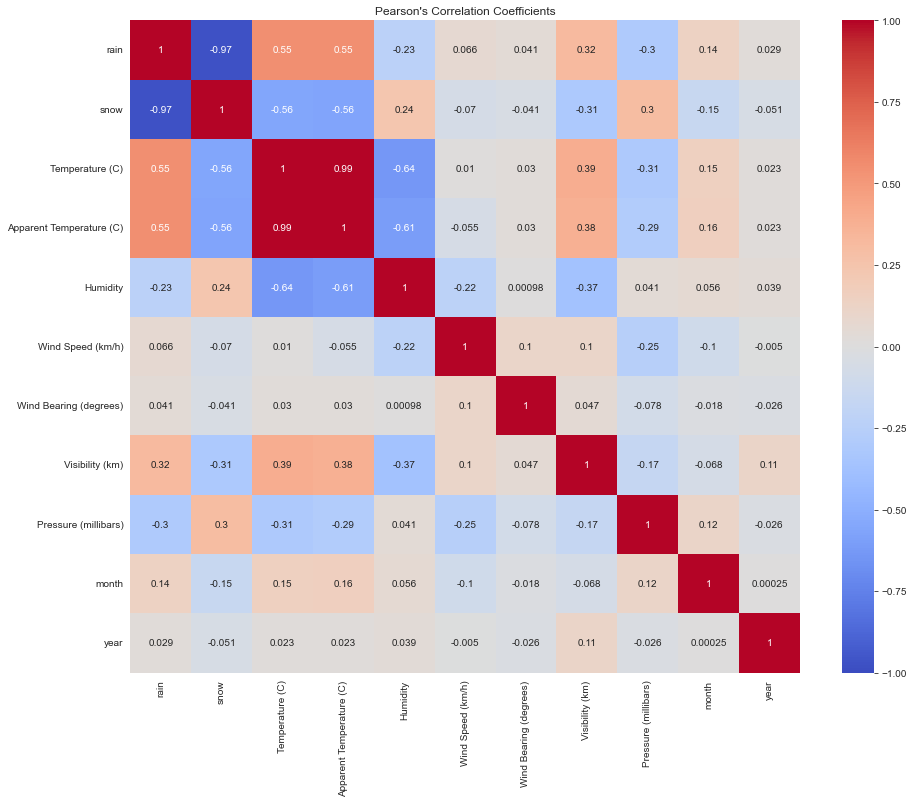

In [29]:
plt.figure(figsize=(15,12))
sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Pearson's Correlation Coefficients")
plt.show()

In [30]:
corr_matrix, p_matrix = spearmanr(weather_df)

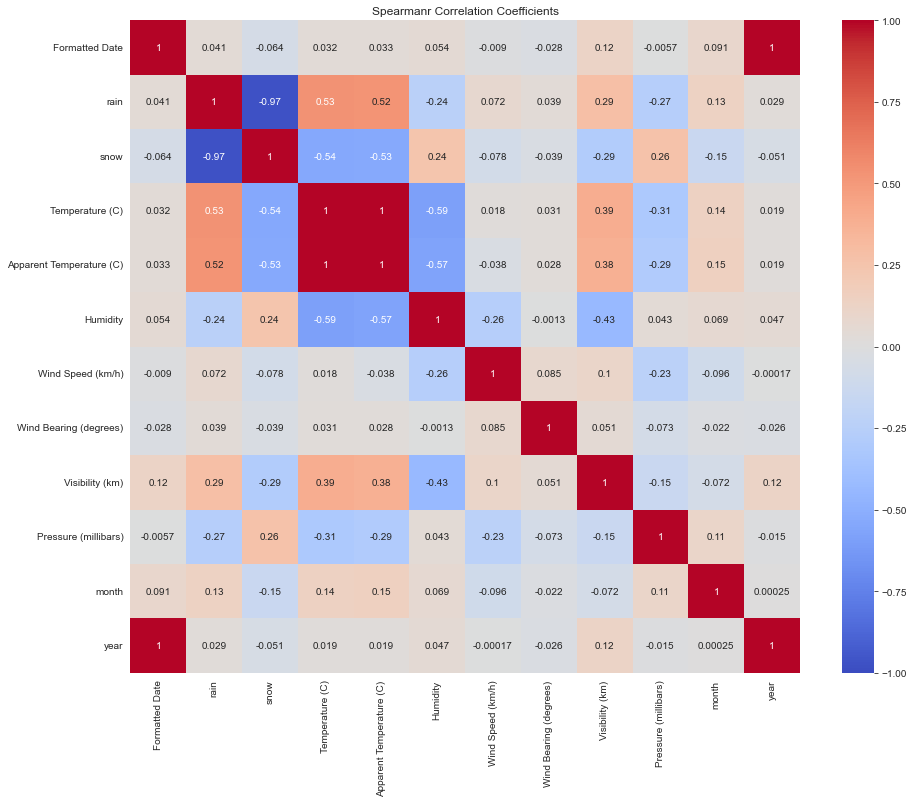

In [31]:
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=weather_df.columns, yticklabels=weather_df.columns, vmin=-1, vmax=1)
plt.title("Spearmanr Correlation Coefficients")
plt.show()

### Sprawdzamy rozkłady zmiennych i jak wyglądają ich zależności.

In [32]:
weather_df.loc[:, 'Temp_diff'] = weather_df.apply(lambda row: row['Temperature (C)'] - row['Apparent Temperature (C)'], axis=1)



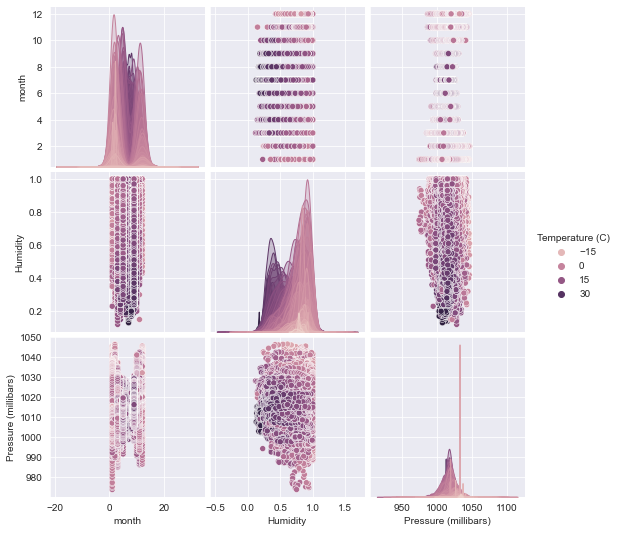

<Figure size 1440x1440 with 0 Axes>

In [33]:
weather_df_pairplot = weather_df[['month', 'Humidity', 'Pressure (millibars)', 'Temperature (C)']]

# plt.clf()
sns.pairplot(data=weather_df_pairplot, hue="Temperature (C)");
plt.figure(figsize=(20, 20)) # z jakiegoś powodu mamy problem ze zwiększeniem tego wykresu 
plt.show()

Warto jeszcze zbadać zależność ciśnienia od miesiąca i duży pik wartości na histogramie ciśnienia. 

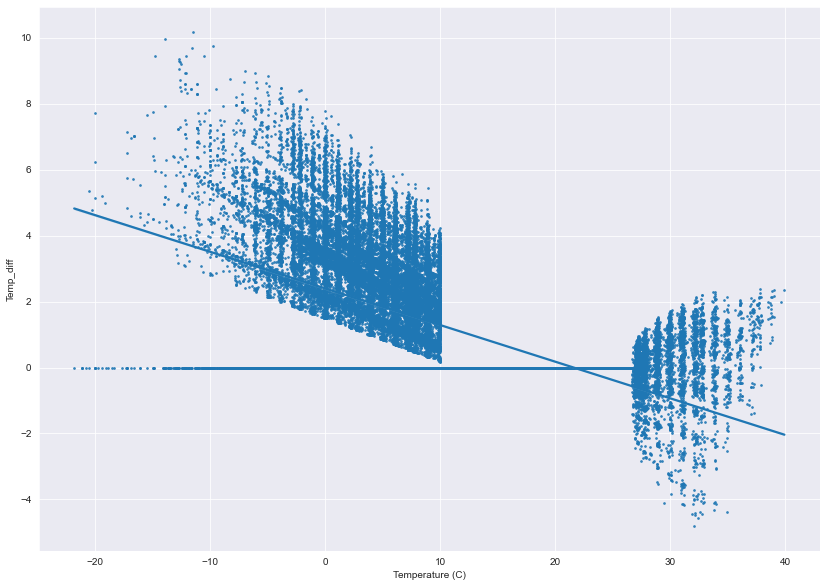

In [34]:
plt.figure(figsize=(14,10))
sns.regplot(data=weather_df, x=weather_df['Temperature (C)'], y=weather_df['Temp_diff'], scatter_kws={'s': 3});


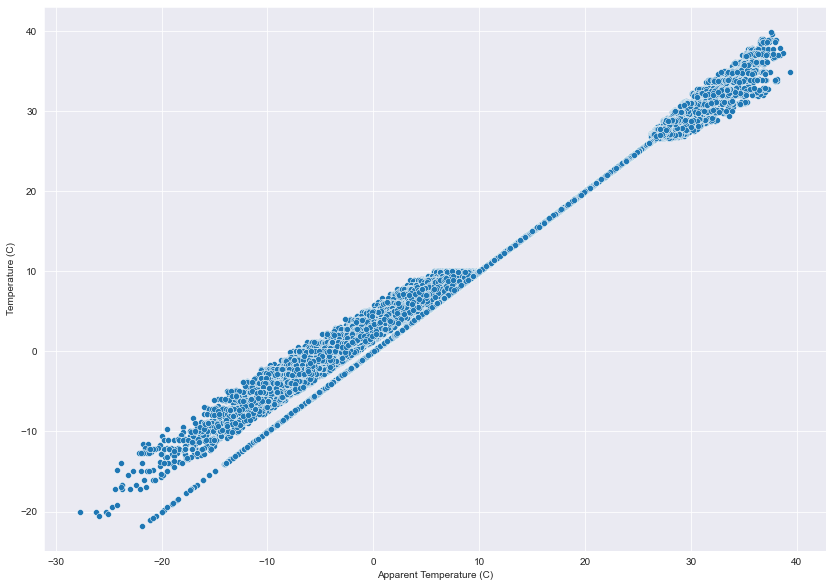

In [35]:
plt.figure(figsize=(14,10))
sns.scatterplot(x=weather_df['Apparent Temperature (C)'], y=weather_df['Temperature (C)'], data=weather_df);

Wniosek: **'Apparent Temperature (C)'** zostały częściowo zastapione przez **'Temperature (C)'**

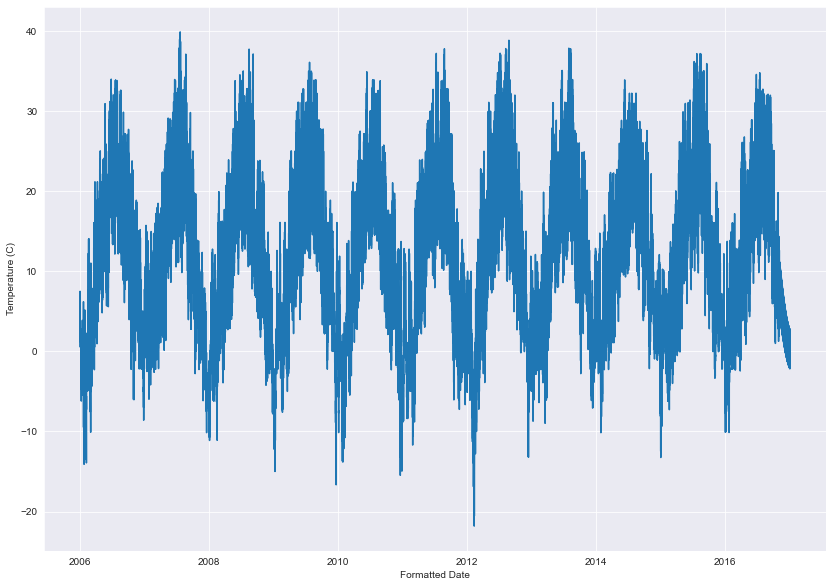

In [36]:
plt.figure(figsize=(14,10))
sns.lineplot(data=weather_df, x=weather_df['Formatted Date'], y=weather_df['Temperature (C)']);



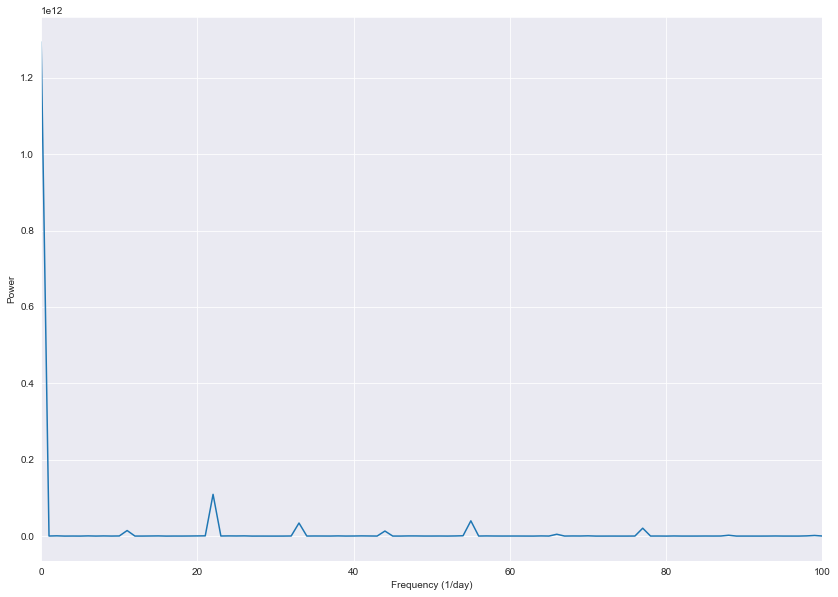

In [37]:
# Analiza FFT przebiegu czasowego (WORK IN PROGRESS), Wiktor czy stosujecie tego typu rzeczy dla przebiegów czasowych?

temp_data = weather_df['Temperature (C)'].to_numpy()

# Compute the FFT of the temperature data
fft = np.fft.fft(temp_data)

# Compute the power spectrum (magnitude squared of the FFT)
power_spectrum = np.abs(fft) ** 2

# Compute the frequencies corresponding to each point in the FFT
freqs = np.fft.fftfreq(len(temp_data), d=1/len(temp_data))

# Find the positive frequencies (since the FFT is symmetric)
pos_freqs = freqs[:len(freqs)//2]

# Plot the power spectrum as a function of frequency
plt.figure(figsize=(14,10))
plt.plot(pos_freqs, power_spectrum[:len(power_spectrum)//2])
plt.xlabel('Frequency (1/day)')
# plt.xlim(0, 400)
plt.xlim(0, 100)
plt.ylabel('Power')
# plt.ylim(0, 4)
plt.show()

Text(0.5, 0, 'Humidity')

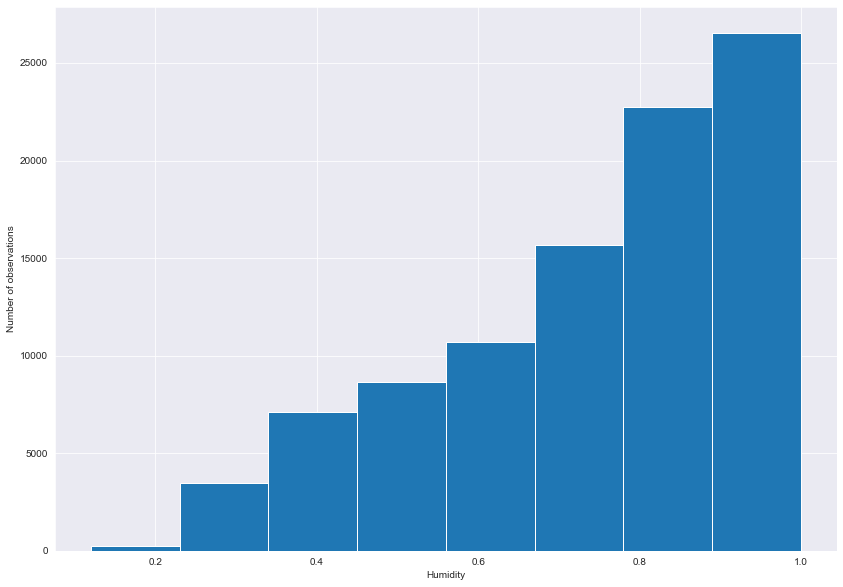

In [38]:
plt.figure(figsize=(14,10))
fig = weather_df.Humidity.hist(bins=8)
fig.set_ylabel('Number of observations')
fig.set_xlabel('Humidity')

Text(0.5, 0, 'Visibility (km)')

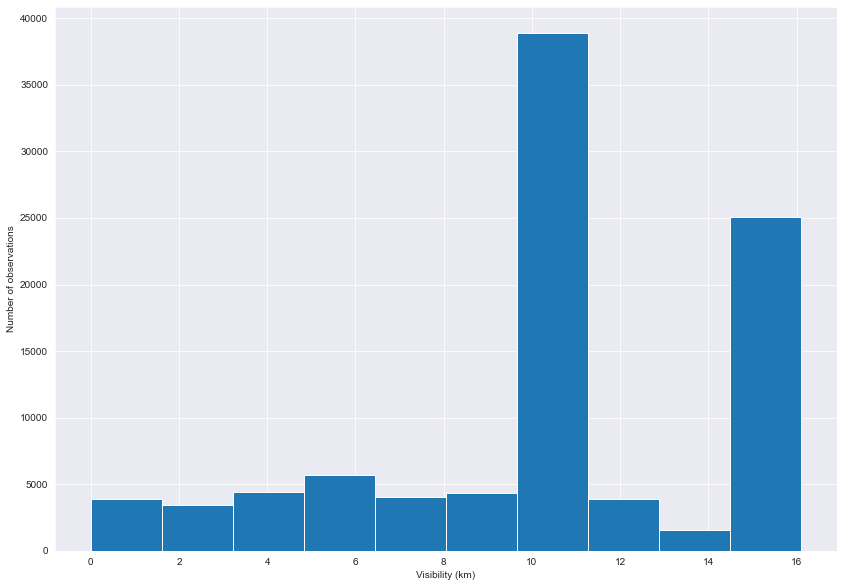

In [39]:
plt.figure(figsize=(14,10))
fig = weather_df['Visibility (km)'].hist(bins=10)
fig.set_ylabel('Number of observations')
fig.set_xlabel('Visibility (km)')

<AxesSubplot:xlabel='Humidity', ylabel='Temperature (C)'>

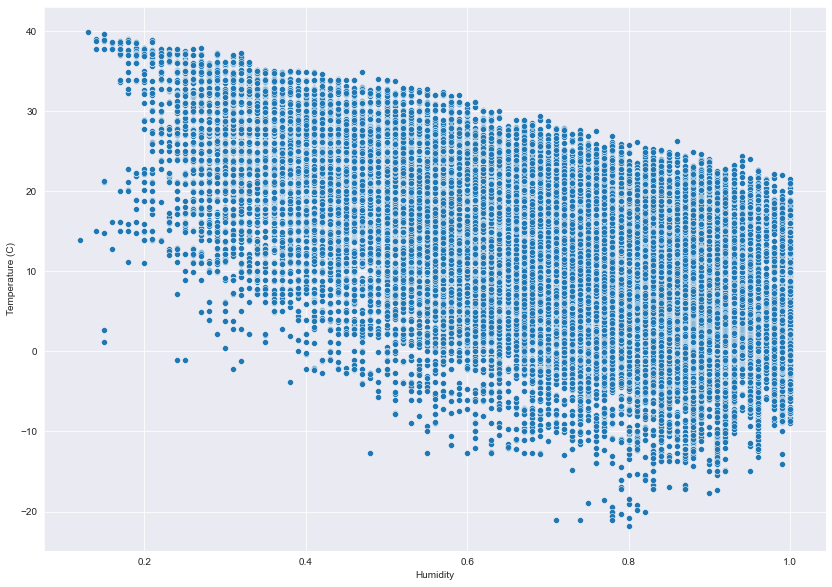

In [40]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=weather_df, x=weather_df['Humidity'], y=weather_df['Temperature (C)'])

<AxesSubplot:xlabel='Temperature (C)', ylabel='rain'>

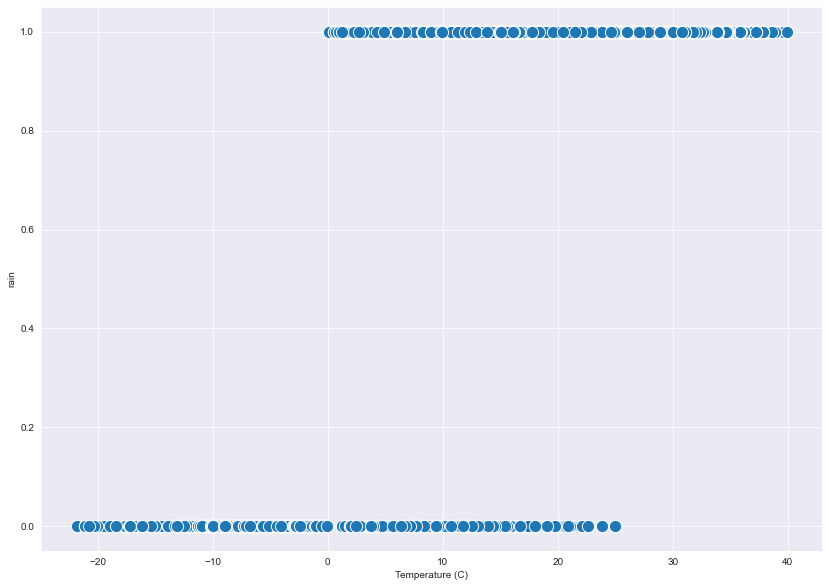

In [41]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=weather_df, x=weather_df['Temperature (C)'], y=weather_df['rain'], s = 150)

<AxesSubplot:xlabel='Temperature (C)', ylabel='snow'>

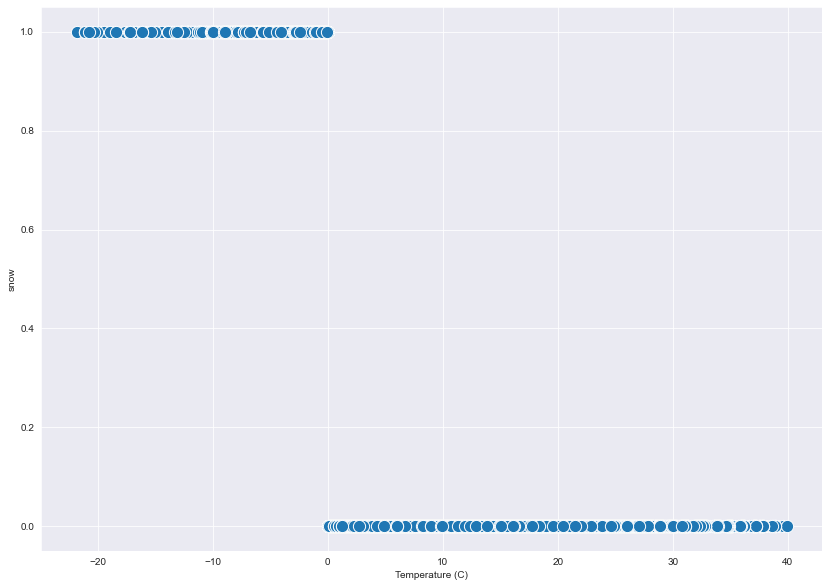

In [42]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=weather_df, x=weather_df['Temperature (C)'], y=weather_df['snow'], s = 150)

<AxesSubplot:xlabel='Temperature (C)', ylabel='Wind Speed (km/h)'>

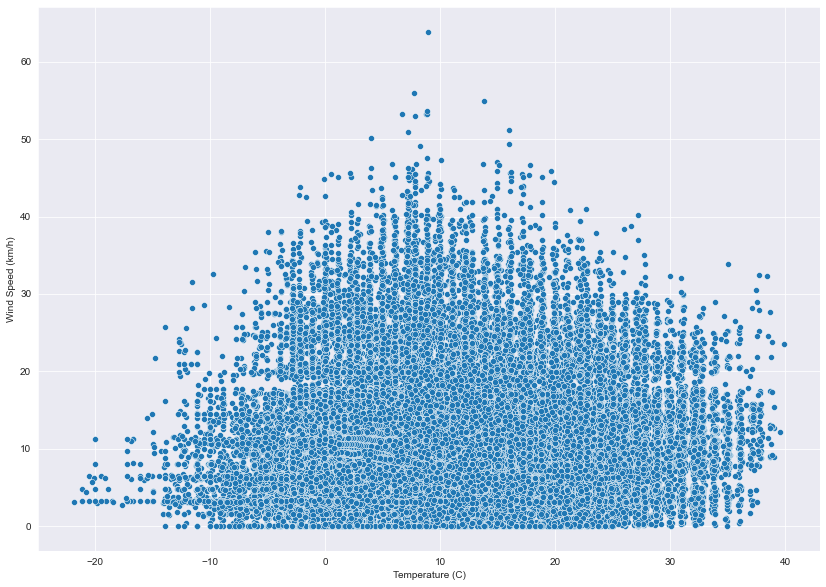

In [43]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=weather_df, x=weather_df['Temperature (C)'], y=weather_df['Wind Speed (km/h)'])

<AxesSubplot:xlabel='Temperature (C)', ylabel='Wind Bearing (degrees)'>

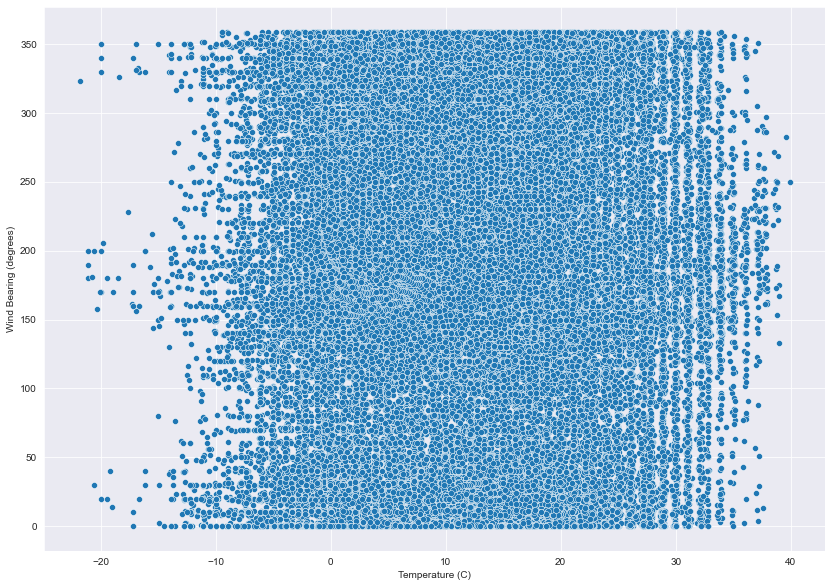

In [44]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=weather_df, x=weather_df['Temperature (C)'], y=weather_df['Wind Bearing (degrees)'])

<AxesSubplot:xlabel='Temperature (C)', ylabel='Visibility (km)'>

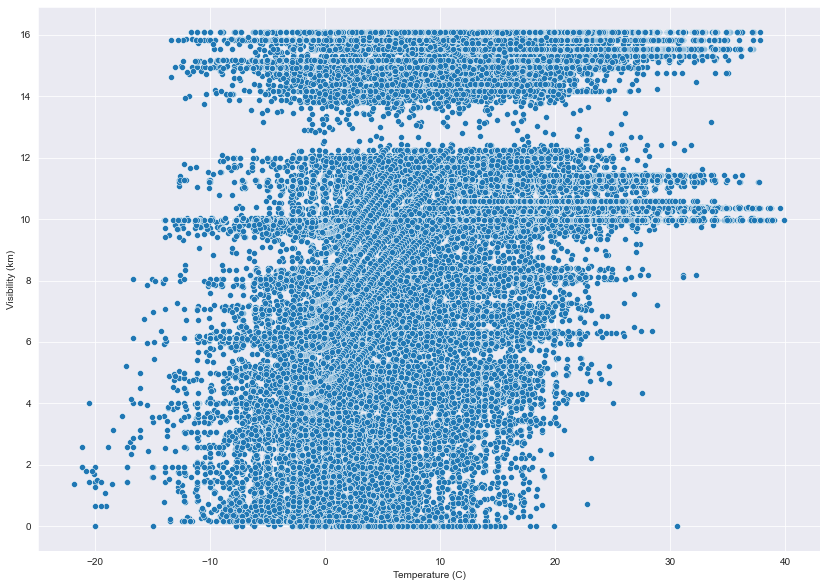

In [45]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=weather_df, x=weather_df['Temperature (C)'], y=weather_df['Visibility (km)'])

Widoczność zwiększa się wraz ze wzrostem temperatury:

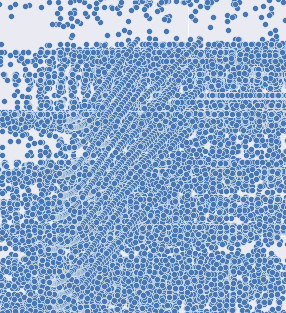




<AxesSubplot:xlabel='Temperature (C)', ylabel='Pressure (millibars)'>

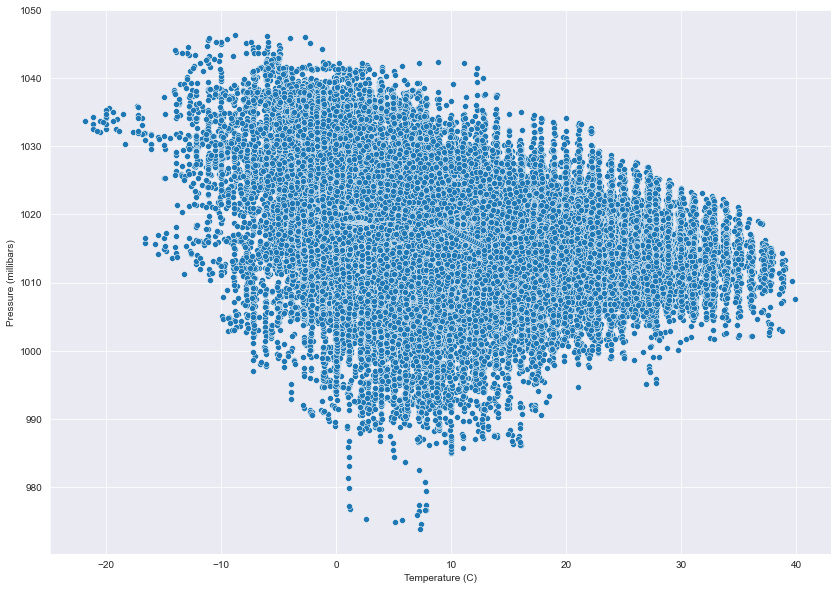

In [46]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=weather_df, x=weather_df['Temperature (C)'], y=weather_df['Pressure (millibars)'])

Text(0.5, 0, 'Temperature (C)')

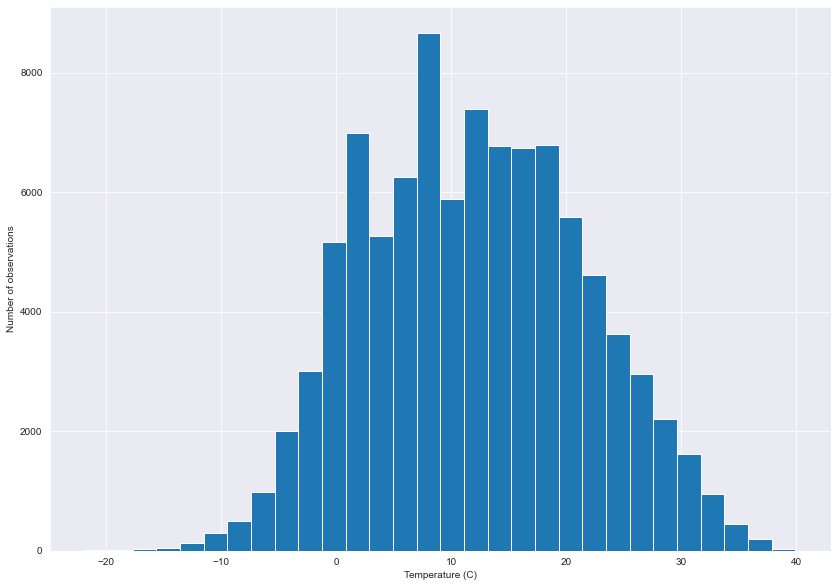

In [47]:
plt.figure(figsize=(14,10))
fig = weather_df['Temperature (C)'].hist(bins=30)
fig.set_ylabel('Number of observations')
fig.set_xlabel('Temperature (C)')

### Wykresy gęstości rozkładu danych
(ze względu na sporą ilość obserwacji wyrysowanie wykresu może zająć kilka minut)

In [48]:
# sns.kdeplot(data=weather_df, x=weather_df['Wind Speed (km/h)'], y=weather_df['Temperature (C)'])

In [49]:
# sns.kdeplot(data=weather_df, x=weather_df['Pressure (millibars)'], y=weather_df['Temperature (C)'])
# plt.xscale('log')

In [50]:
# sns.kdeplot(data=weather_df, x=weather_df['Visibility (km)'], y=weather_df['Temperature (C)'])

In [51]:
# sns.kdeplot(data=weather_df, x=weather_df['Wind Bearing (degrees)'], y=weather_df['Temperature (C)'])


### Hipotezy: 
#### * przewidywanie wysokości temp w zależności od czasu
#### * przewidywanie wysokości temp w zależności od pozostałych zmiennych
#### * ~przewidywanie róznicy pomiędzy temp odczuwalną a temp (niekompletne dane dotyczące temp odczuwalnej)~
#### * ~przewidywania opadu w zależności od zachmurzenia, temp i ciśnienia (po wstępnej analizie danych doszliśmy do wniosku, że prezentują one opis pogody, gdy pada deszcz lub śnieg - na 96453 tylko 517 przypadków braku opadów)~
#### * ~przewidywanie widoczności od opadu, zachmurzenia, wiatru, wilgotności (dane dotyczące opadów są mało zróżnicowane)~


### Przygotowanie danych

In [52]:
weather_df


Formatted Date  rain  snow  Temperature (C)  \
0     2006-03-31 22:00:00+00:00     1     0         9.472222   
1     2006-03-31 23:00:00+00:00     1     0         9.355556   
2     2006-04-01 00:00:00+00:00     1     0         9.377778   
3     2006-04-01 01:00:00+00:00     1     0         8.288889   
4     2006-04-01 02:00:00+00:00     1     0         8.755556   
...                         ...   ...   ...              ...   
95138 2016-09-09 17:00:00+00:00     1     0        26.016667   
95139 2016-09-09 18:00:00+00:00     1     0        24.583333   
95140 2016-09-09 19:00:00+00:00     1     0        22.038889   
95141 2016-09-09 20:00:00+00:00     1     0        21.522222   
95142 2016-09-09 21:00:00+00:00     1     0        20.438889   

       Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                      7.388889      0.89            14.1197   
1                      7.227778      0.86            14.2646   
2                      9.377778      0.89             3.9284   
3                      5.944444      0.83            14.1036   
4                      6.977778      0.83            11.0446   
...                         ...       ...                ...   
95138                 26.016667      0.43            10.9963   
95139                 24.583333      0.48            10.0947   
95140                 22.038889      0.56             8.9838   
95141                 21.522222      0.60            10.5294   
95142                 20.438889      0.61             5.8765   

       Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  month  \
0                       251.0          15.8263               1015.13      3   
1                       259.0          15.8263               1015.63      3   
2                       204.0          14.9569               1015.94      4   
3                       269.0          15.8263               1016.41      4   
4                       259.0          15.8263               1016.51      4   
...                       ...              ...                   ...    ...   
95138                    31.0          16.1000               1014.36      9   
95139                    20.0          15.5526               1015.16      9   
95140                    30.0          16.1000               1015.66      9   
95141                    20.0          16.1000               1015.95      9   
95142                    39.0          15.5204               1016.16      9   

       year  Temp_diff  
0      2006   2.083333  
1      2006   2.127778  
2      2006   0.000000  
3      2006   2.344444  
4      2006   1.777778  
...     ...        ...  
95138  2016   0.000000  
95139  2016   0.000000  
95140  2016   0.000000  
95141  2016   0.000000  
95142  2016   0.000000  

[95143 rows x 13 columns]

In [53]:
if (weather_df.index == pd.RangeIndex(start=0, stop=len(weather_df), step=1)).all():
    print("Index is reset.")
else:
    print("Index is not reset.")

Index is reset.


#STOP - Wiktor - jak zrobić STOP przy puszczaniu Jupytera od początku ?

In [201]:
X1 = weather_df[['month']]
X2 = weather_df[['month','Humidity','Apparent Temperature (C)','Wind Speed (km/h)','Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)']]
X3 = weather_df[['month','Humidity','Apparent Temperature (C)','Wind Speed (km/h)','Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)', 'rain', 'snow']]

y = weather_df['Temperature (C)']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size = 0.2, random_state = 42)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size=0.25, random_state = 42)

X1_train.reset_index(drop=True, inplace=True)
y1_train.reset_index(drop=True, inplace=True)
X1_val.reset_index(drop=True, inplace=True)
y1_val.reset_index(drop=True, inplace=True)
X1_test.reset_index(drop=True, inplace=True)
y1_test.reset_index(drop=True, inplace=True)


# print("######################")

# print(X1_train.tail(2), X1_train.shape)
# print(y1_train.tail(2), y1_train.shape)
# print(X1_val.tail(2), X1_val.shape)
# print(y1_val.tail(2), y1_val.shape)
# print(X1_test.tail(2), X1_test.shape)
# print(y1_test.tail(2), y1_test.shape)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.2, random_state = 42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.25, random_state = 42)

# print("######################")

# print(X2_train.tail(2), X2_train.shape)
# print(y2_train.tail(2), y2_train.shape)
# print(X2_val.tail(2), X2_val.shape)
# print(y2_val.tail(2), y2_val.shape)
# print(X2_test.tail(2), X2_test.shape)
# print(y2_test.tail(2), y2_test.shape)

X2_train.reset_index(drop=True, inplace=True)
y2_train.reset_index(drop=True, inplace=True)
X2_val.reset_index(drop=True, inplace=True)
y2_val.reset_index(drop=True, inplace=True)
X2_test.reset_index(drop=True, inplace=True)
y2_test.reset_index(drop=True, inplace=True)


X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size = 0.2, random_state = 42)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3_train, y3_train, test_size=0.25, random_state = 42)


# print("######################")

# print(X3_train.tail(2), X3_train.shape)
# print(y3_train.tail(2), y3_train.shape)
# print(X3_val.tail(2), X3_val.shape)
# print(y3_val.tail(2), y3_val.shape)
# print(X3_test.tail(2), X3_test.shape)
# print(y3_test.tail(2), y3_test.shape)

X3_train.reset_index(drop=True, inplace=True)
y3_train.reset_index(drop=True, inplace=True)
X3_val.reset_index(drop=True, inplace=True)
y3_val.reset_index(drop=True, inplace=True)
X3_test.reset_index(drop=True, inplace=True)
y3_test.reset_index(drop=True, inplace=True)

X3

month  Humidity  Apparent Temperature (C)  Wind Speed (km/h)  \
0          3      0.89                  7.388889            14.1197   
1          3      0.86                  7.227778            14.2646   
2          4      0.89                  9.377778             3.9284   
3          4      0.83                  5.944444            14.1036   
4          4      0.83                  6.977778            11.0446   
...      ...       ...                       ...                ...   
95138      9      0.43                 26.016667            10.9963   
95139      9      0.48                 24.583333            10.0947   
95140      9      0.56                 22.038889             8.9838   
95141      9      0.60                 21.522222            10.5294   
95142      9      0.61                 20.438889             5.8765   

       Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  rain  \
0                       251.0          15.8263               1015.13     1   
1                       259.0          15.8263               1015.63     1   
2                       204.0          14.9569               1015.94     1   
3                       269.0          15.8263               1016.41     1   
4                       259.0          15.8263               1016.51     1   
...                       ...              ...                   ...   ...   
95138                    31.0          16.1000               1014.36     1   
95139                    20.0          15.5526               1015.16     1   
95140                    30.0          16.1000               1015.66     1   
95141                    20.0          16.1000               1015.95     1   
95142                    39.0          15.5204               1016.16     1   

       snow  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
95138     0  
95139     0  
95140     0  
95141     0  
95142     0  

[95143 rows x 9 columns]

In [202]:
if (X2_train.index == pd.RangeIndex(start=0, stop=len(X2_train), step=1)).all():
    print("Index is reset.")
else:
    print("Index is not reset.")

Index is reset.


In [203]:
X3_train.head()

month  Humidity  Apparent Temperature (C)  Wind Speed (km/h)  \
0      9      0.39                 20.955556            16.1322   
1      5      0.86                 10.911111             9.2736   
2      1      0.88                 -5.238889            12.7190   
3      3      0.93                 -0.872222            26.4201   
4     11      0.73                 10.594444            13.2664   

   Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  rain  snow  
0                   270.0          10.3523               1016.41     1     0  
1                    52.0           9.9015               1013.95     1     0  
2                   140.0           7.8246               1028.98     0     1  
3                    19.0           7.0679                989.98     1     0  
4                   174.0          10.1913               1019.74     1     0

### 1. Model regresji liniowej z wykorzystaniem równania normalnego

In [209]:
model1_weather = LinearRegression()
model1_weather.fit(X1_train,y1_train)
a0 = model1_weather.intercept_
a1 = model1_weather.coef_
print("a1: ", model1_weather.coef_)
print("a0: ", model1_weather.intercept_)

model1_predictions = model1_weather.predict(X1_test) 


a1:  [0.41041835]
a0:  9.330087137861637


<AxesSubplot:xlabel='month', ylabel='Temperature (C)'>

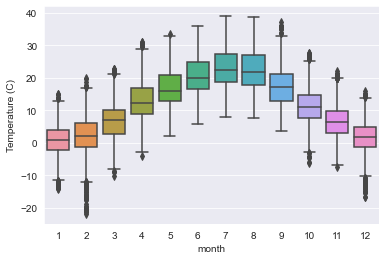

In [210]:
sns.boxplot(x=X1_train['month'], y=y1_train)

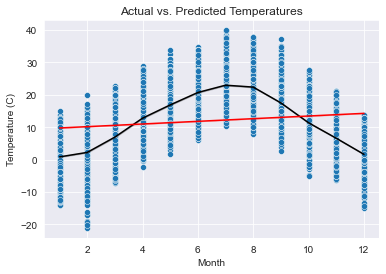

In [226]:
sns.scatterplot(x=X1_test['month'], y=y1_test)
sns.lineplot(x=weather_df['month'], y=weather_df['Temperature (C)'], color = 'black');
sns.lineplot(x=X1_test['month'], y = a1* X1_test['month'] + a0, color='red')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Month')
plt.ylabel('Temperature (C)')
plt.show()

In [212]:
model_1_mae = mean_absolute_error(y1_test, model1_predictions)
print(f'Model_1 MAE = {model_1_mae}')
model_1_mse = mean_squared_error(y1_test, model1_predictions)
print(f'Model_1 MSE = {model_1_mse}')
model_1_mape = mean_absolute_percentage_error(y1_test, model1_predictions)
print(f'Model_1 MAPE = {model_1_mape}')
model_1_wmape = wmape(y1_test, model1_predictions)
print(f'Model_1 WMAPE = {model_1_wmape}')
model_1_r2score = r2_score(y1_test, model1_predictions)
print(f'Model_1 R2Score = {model_1_r2score}')

Model_1 MAE = 7.8135629613605975
Model_1 MSE = 88.8110076661385
Model_1 MAPE = 162814407889981.25
Model_1 WMAPE = 65.43689741102203
Model_1 R2Score = 0.026875894277037404


#### 2. Model regresji liniowej + algorytm stochastycznego spadku wzdłuż gradientu


In [61]:
model2_weather = SGDRegressor()
model2_weather.fit(X1_train,y1_train)
a1=model2_weather.coef_[0]
a0=model2_weather.intercept_[0]
print("a1: ", model2_weather.coef_)
print("a0: ", model2_weather.intercept_)
model2_predictions = model2_weather.predict(X1_test)

a1:  [0.323758]
a0:  [9.33353907]


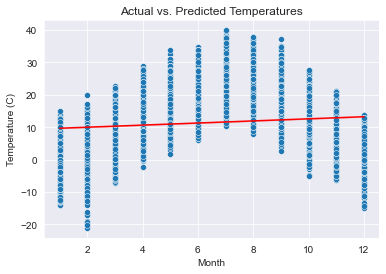

In [62]:
sns.scatterplot(x=X1_test['month'], y=y1_test)
sns.lineplot(x=X1_test['month'], y = a1* X1_test['month'] + a0, color='red')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Month')
plt.ylabel('Temperature (C)')
plt.show()

In [63]:
model_2_mae = mean_absolute_error(y1_test, model2_predictions)
print(f'Model_2 MAE = {model_2_mae}')
model_2_mse = mean_squared_error(y1_test, model2_predictions)
print(f'Model_2 MSE = {model_2_mse}')
model_2_mape = mean_absolute_percentage_error(y1_test, model2_predictions)
print(f'Model_2 MAPE = {model_2_mape}')
model_2_wmape = wmape(y1_test, model2_predictions)
print(f'Model_2 WMAPE = {model_2_wmape}')
model_2_r2score = r2_score(y1_test, model2_predictions)
print(f'Model_2 R2Score = {model_2_r2score}')

Model_2 MAE = 7.830788552666182
Model_2 MSE = 89.24896720638951
Model_2 MAPE = 157861453401546.62
Model_2 WMAPE = 65.58115800720356
Model_2 R2Score = 0.022077063623614945


### 3. Model regresji wielomianowej (możliwość dostrojenia hiperparametrów) - 1 parametr



In [228]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_train = poly.fit_transform(X1_train)
poly_test = poly.transform(X1_val) # używam zbioru walidacyjnego 
model3_weather = LinearRegression()
model3_weather.fit(poly_train, y1_train)
model3_predictions = model3_weather.predict(poly_test) 

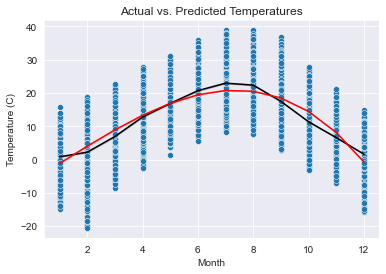

In [229]:
sns.scatterplot(x=X1_val['month'], y=y1_val)
sns.lineplot(x=weather_df['month'], y=weather_df['Temperature (C)'], color = 'black');
sns.lineplot(x=X1_val['month'], y = model3_predictions, color='red')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Month')
plt.ylabel('Temperature (C)')
plt.show()

In [66]:
# używam zbioru walidacyjnego (degree 2):
model3_predictions = model3_weather.predict(poly.transform(X1_val)) 

model_3_mae = mean_absolute_error(y1_val, model3_predictions)
print(f'Model_3 MAE = {model_3_mae.round(3)}')
model_3_mse = mean_squared_error(y1_val, model3_predictions)
print(f'Model_3 MSE = {model_3_mse.round(3)}')
model_3_mape = mean_absolute_percentage_error(y1_val, model3_predictions)
print(f'Model_3 MAPE = {model_3_mape.round(3)}')
model_3_wmape = wmape(y1_val, model3_predictions)
print(f'Model_3 WMAPE = {model_3_wmape.round(3)}')
model_3_r2score = r2_score(y1_val, model3_predictions)
print(f'Model_3 R2Score = {model_3_r2score.round(3)}')


Model_3 MAE = 4.597
Model_3 MSE = 32.432
Model_3 MAPE = 46229223739218.34
Model_3 WMAPE = 38.908
Model_3 R2Score = 0.642


degree 2: <br>
Model_3 MAE = 4.704 <br>
Model_3 MSE = 34.146 <br> 
Model_3 MAPE = 59260283606164.68 <br>
Model_3 WMAPE = 39.814 <br>
Model_3 R2Score = 0.623 <br>

degree 3: <br>
Model_3 MAE = 4.597 <br>
Model_3 MSE = 32.432 <br> 
Model_3 MAPE = 46229223739218.34 <br>
Model_3 WMAPE = 38.908 <br>
Model_3 R2Score = 0.642 <br>




In [67]:
# używam zbioru testowego (degree 2 daje najlepsze rezultaty na zbiorze walidacyjnym):
model3_predictions = model3_weather.predict(poly.transform(X1_test)) 

model_3_mae = mean_absolute_error(y1_test, model3_predictions)
print(f'Model_3 MAE = {model_3_mae.round(3)}')
model_3_mse = mean_squared_error(y1_test, model3_predictions)
print(f'Model_3 MSE = {model_3_mse.round(3)}')
model_3_mape = mean_absolute_percentage_error(y1_test, model3_predictions)
print(f'Model_3 MAPE = {model_3_mape.round(3)}')
model_3_wmape = wmape(y1_test, model3_predictions)
print(f'Model_3 WMAPE = {model_3_wmape.round(3)}')
model_3_r2score = r2_score(y1_test, model3_predictions)
print(f'Model_3 R2Score = {model_3_r2score.round(3)}')

Model_3 MAE = 4.629
Model_3 MSE = 32.792
Model_3 MAPE = 39039729245789.73
Model_3 WMAPE = 38.763
Model_3 R2Score = 0.641


### 4. Drzewo decyzyjne  (możliwość dostrojenia hiperparametrów)

In [231]:
model4_weather = DecisionTreeRegressor(max_depth=2)
model4_weather.fit(X1_train,y1_train)
model4_predictions = model4_weather.predict(X1_val)
print(model4_predictions)

[ 6.49729302  6.86815286  6.49729302 ... 18.90328021 18.90328021
 18.90328021]


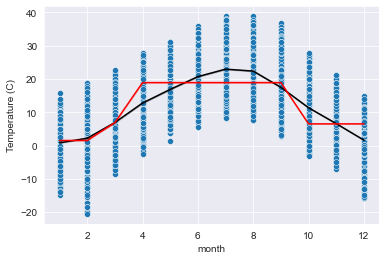

In [232]:
sns.scatterplot(x=X1_val['month'], y=y1_val)
sns.lineplot(x=weather_df['month'], y=weather_df['Temperature (C)'], color = 'black');
sns.lineplot(x=X1_val['month'], y=model4_predictions, color = 'red');

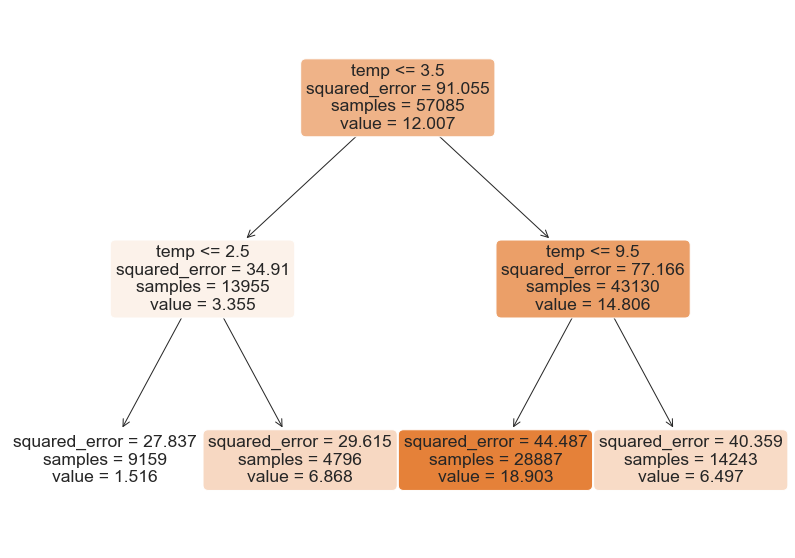

In [70]:
plt.figure(figsize=(14,10))
sklearn.tree.plot_tree(model4_weather, feature_names = ["temp"], filled = True, rounded = True);

In [71]:
model_4_mae = mean_absolute_error(y1_val, model4_predictions)
print(f'Model_4 MAE = {model_4_mae.round(3)}')
model_4_mse = mean_squared_error(y1_val, model4_predictions)
print(f'Model_4 MSE = {model_4_mse.round(3)}')
model_4_mape = mean_absolute_percentage_error(y1_val, model4_predictions)
print(f'Model_4 MAPE = {model_4_mape.round(3)}')
model_4_wmape = wmape(y1_val, model4_predictions)
print(f'Model_4 WMAPE = {model_4_wmape.round(3)}')
model_4_r2score = r2_score(y1_val, model4_predictions)
print(f'Model_4 R2Score = {model_4_r2score.round(3)}')

Model_4 MAE = 5.021
Model_4 MSE = 39.599
Model_4 MAPE = 38892733706893.79
Model_4 WMAPE = 42.499
Model_4 R2Score = 0.563


max_depth=2 <br>

Model_4 MAE = 5.021 <br>
Model_4 MSE = 39.599 <br>
Model_4 MAPE = 38892733706893.79 <br>
Model_4 WMAPE = 42.499 <br>
Model_4 R2Score = 0.563 <br>

max_depth=3 <br>
Model_4 MAE = 4.581 <br>
Model_4 MSE = 32.62 <br>
Model_4 MAPE = 33664231681795.176 <br>
Model_4 WMAPE = 38.775 <br>
Model_4 R2Score = 0.64 <br>


In [72]:
model4_predictions = model4_weather.predict(X1_test)

model_4_mae = mean_absolute_error(y1_test, model4_predictions)
print(f'Model_4 MAE = {model_4_mae.round(3)}')
model_4_mse = mean_squared_error(y1_test, model4_predictions)
print(f'Model_4 MSE = {model_4_mse.round(3)}')
model_4_mape = mean_absolute_percentage_error(y1_test, model4_predictions)
print(f'Model_4 MAPE = {model_4_mape.round(3)}')
model_4_wmape = wmape(y1_test, model4_predictions)
print(f'Model_4 WMAPE = {model_4_wmape.round(3)}')
model_4_r2score = r2_score(y1_test, model4_predictions)
print(f'Model_4 R2Score = {model_4_r2score.round(3)}')

Model_4 MAE = 5.031
Model_4 MSE = 39.78
Model_4 MAPE = 45438740373940.055
Model_4 WMAPE = 42.134
Model_4 R2Score = 0.564


### 5. Regresja grzbietowa

In [73]:
model5_weather = Ridge(alpha = 1)
model5_weather.fit(standardization(X1_train), y1_train) # standaryzujemy tylko X ?
model5_predictions = model5_weather.predict(X1_test)

model5_predictions

array([21.8737561 , 19.05469271, 23.28328779, ..., 14.82609763,
       28.92141456, 28.92141456])

<AxesSubplot:xlabel='month', ylabel='Temperature (C)'>

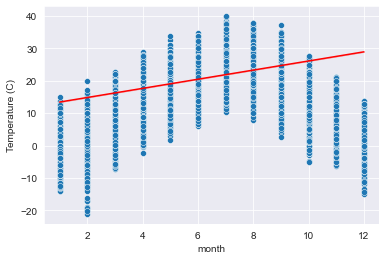

In [74]:
sns.scatterplot(x=X1_test['month'], y=y1_test);
sns.lineplot(x=X1_test['month'], y=model5_predictions, color = 'red');

In [75]:
model_5_mae = mean_absolute_error(y1_test, model5_predictions)
print(f'Model_5 MAE = {model_5_mae.round(3)}')
model_5_mse = mean_squared_error(y1_test, model5_predictions)
print(f'Model_5 MSE = {model_5_mse.round(3)}')
model_5_mape = mean_absolute_percentage_error(y1_test, model5_predictions)
print(f'Model_5 MAPE = {model_5_mape.round(3)}')
model_5_wmape = wmape(y1_test, model5_predictions)
print(f'Model_5 WMAPE = {model_5_wmape.round(3)}')
model_5_r2score = r2_score(y1_test, model5_predictions)
print(f'Model_5 R2Score = {model_5_r2score.round(3)}')

Model_5 MAE = 10.889
Model_5 MSE = 184.476
Model_5 MAPE = 260424663719838.12
Model_5 WMAPE = 91.195
Model_5 R2Score = -1.021


### 6. Regresja LASSO

In [76]:
model6_weather = Ridge(alpha = 1)
model6_weather.fit(X1_train, y1_train)

Ridge(alpha=1)

In [77]:
model6_predictions = model6_weather.predict(X1_test)

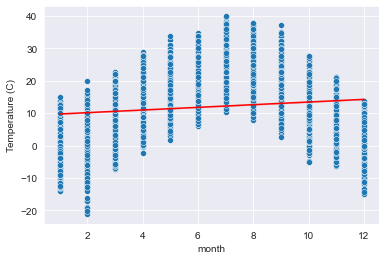

In [78]:
sns.scatterplot(x=X1_test['month'], y=y1_test)
sns.lineplot(x=X1_test['month'], y=model6_predictions, color = 'red');

In [79]:
model_6_mae = mean_absolute_error(y1_test, model6_predictions)
print(f'Model_6 MAE = {model_6_mae.round(3)}')
model_6_mse = mean_squared_error(y1_test, model6_predictions)
print(f'Model_6 MSE = {model_6_mse.round(3)}')
model_6_mape = mean_absolute_percentage_error(y1_test, model6_predictions)
print(f'Model_6 MAPE = {model_6_mape.round(3)}')
model_6_wmape = wmape(y1_test, model6_predictions)
print(f'Model_6 WMAPE = {model_6_wmape.round(3)}')
model_6_r2score = r2_score(y1_test, model6_predictions)
print(f'Model_6 R2Score = {model_6_r2score.round(3)}')

Model_6 MAE = 7.814
Model_6 MSE = 88.811
Model_6 MAPE = 162814431968834.3
Model_6 WMAPE = 65.437
Model_6 R2Score = 0.027


### 7. Metoda elastycznej siatki

In [80]:
model7_weather = ElasticNet(alpha = 2, l1_ratio = 1)
model7_weather.fit(X1_train, y1_train)
model7_predictions = model7_weather.predict(X1_test)

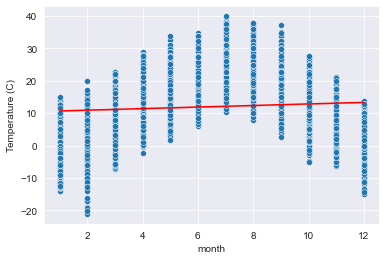

In [81]:
sns.scatterplot(x=X1_test['month'], y=y1_test)
sns.lineplot(x=X1_test['month'], y=model7_predictions, color = 'red');

In [82]:
model_7_mae = mean_absolute_error(y1_test, model7_predictions)
print(f'Model_7 MAE = {model_7_mae.round(3)}')
model_7_mse = mean_squared_error(y1_test, model7_predictions)
print(f'Model_7 MSE = {model_7_mse.round(3)}')
model_7_mape = mean_absolute_percentage_error(y1_test, model7_predictions)
print(f'Model_7 MAPE = {model_7_mape.round(3)}')
model_7_wmape = wmape(y1_test, model7_predictions)
print(f'Model_7 WMAPE = {model_7_wmape.round(3)}')
model_7_r2score = r2_score(y1_test, model7_predictions)
print(f'Model_7 R2Score = {model_7_r2score.round(3)}')

Model_7 MAE = 7.846
Model_7 MSE = 89.34
Model_7 MAPE = 169512662988920.38
Model_7 WMAPE = 65.707
Model_7 R2Score = 0.021


### 8. Regresja liniowa dla wielu zmiennych

In [234]:
model8_weather = LinearRegression();
model8_weather.fit(X3_train,y3_train);

In [84]:
a1=model8_weather.coef_
a0=model8_weather.intercept_
a1

array([ 1.54783845e-02, -1.77678666e+00,  8.65506349e-01,  7.18699665e-02,
       -4.09128321e-04,  7.80208647e-03, -2.16601524e-02,  3.39435070e-01,
        4.57428077e-01])

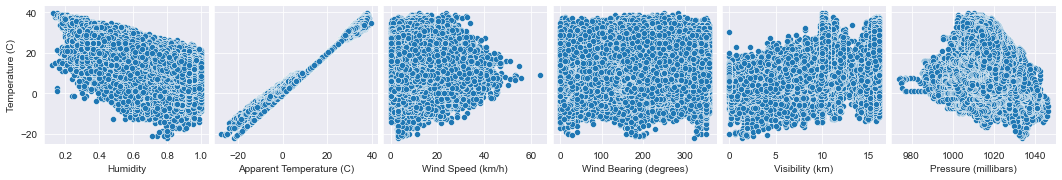

<Figure size 1440x1440 with 0 Axes>

In [233]:
sns.pairplot(data=weather_df, x_vars=['Humidity','Apparent Temperature (C)','Wind Speed (km/h)','Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)'], y_vars='Temperature (C)');
plt.figure(figsize=(20, 20));


In [86]:
model8_predictions = model8_weather.predict(X3_test)

In [87]:
model_8_mae = mean_absolute_error(y3_test, model8_predictions)
print(f'Model_8 MAE = {model_8_mae.round(3)}')
model_8_mse = mean_squared_error(y3_test, model8_predictions)
print(f'Model_8 MSE = {model_8_mse.round(3)}')
model_8_mape = mean_absolute_percentage_error(y3_test, model8_predictions)
print(f'Model_8 MAPE = {model_8_mape.round(3)}')
model_8_wmape = wmape(y3_test, model8_predictions)
print(f'Model_8 WMAPE = {model_8_wmape.round(3)}')
model_8_r2score = r2_score(y3_test, model8_predictions)
print(f'Model_8 r2score = {model_8_r2score.round(3)}')

Model_8 MAE = 0.735
Model_8 MSE = 0.878
Model_8 MAPE = 15997957638513.838
Model_8 WMAPE = 6.151
Model_8 r2score = 0.99


### 9. Regresja wielomianowa dla wielu zmiennych

In [254]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_train = poly.fit_transform(X3_train)
poly_test = poly.transform(X3_test) #dla uproszczenia 
#przechodzę od razu do danych testowych zamiast tesować rózne hiperparametry za pomocą zbioru walidacyjnego degree=3 
#ma lepsze parametry niż 2, nie powinno się zbytnio zwiększać tego parametru (max 3-4)
model9_weather = LinearRegression()
model9_weather.fit(poly_train, y1_train)
model9_predictions = model9_weather.predict(poly_test)

In [255]:
X3_train.head()

month  Humidity  Apparent Temperature (C)  Wind Speed (km/h)  \
0      9      0.39                 20.955556            16.1322   
1      5      0.86                 10.911111             9.2736   
2      1      0.88                 -5.238889            12.7190   
3      3      0.93                 -0.872222            26.4201   
4     11      0.73                 10.594444            13.2664   

   Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  rain  snow  
0                   270.0          10.3523               1016.41     1     0  
1                    52.0           9.9015               1013.95     1     0  
2                   140.0           7.8246               1028.98     0     1  
3                    19.0           7.0679                989.98     1     0  
4                   174.0          10.1913               1019.74     1     0

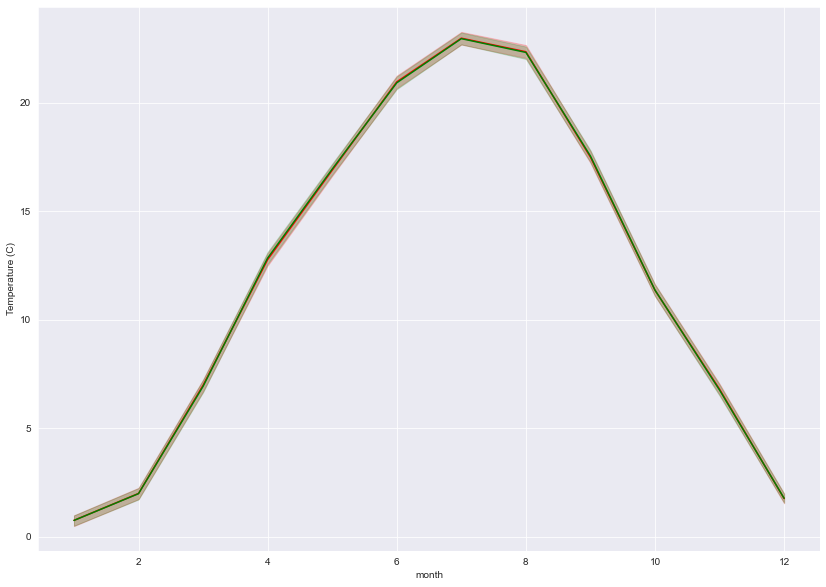

In [256]:
plt.figure(figsize=(14,10))
# sns.scatterplot(x=X1_test['month'], y=y1_test)
sns.lineplot(x=X3_test['month'], y=y3_test, color = 'red');
sns.lineplot(x=X3_test['month'], y=model9_predictions, color = 'green');

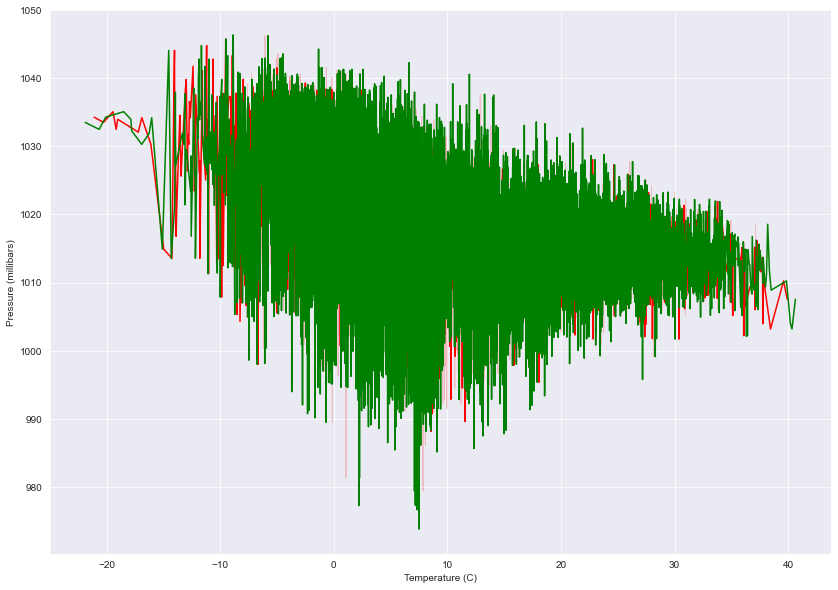

In [258]:
# Just testing different options: 

plt.figure(figsize=(14,10))
# sns.scatterplot(x=X1_test['month'], y=y1_test)
sns.lineplot(x=y3_test, y=X3_test['Pressure (millibars)'], color = 'red');
sns.lineplot(x=model9_predictions, y=X3_test['Pressure (millibars)'], color = 'green');

In [89]:
model_9_mae = mean_absolute_error(y3_test, model9_predictions)
print(f'Model_9 MAE = {model_9_mae.round(3)}')
model_9_mse = mean_squared_error(y3_test, model9_predictions)
print(f'Model_9 MSE = {model_9_mse.round(3)}')
model_9_mape = mean_absolute_percentage_error(y3_test, model9_predictions)
print(f'Model_9 MAPE = {model_9_mape.round(3)}')
model_9_wmape = wmape(y3_test, model9_predictions)
print(f'Model_9 WMAPE = {model_9_wmape.round(3)}')
model_9_r2score = r2_score(y3_test, model9_predictions)
print(f'Model_9 r2score = {model_9_r2score.round(3)}')

Model_9 MAE = 0.317
Model_9 MSE = 0.175
Model_9 MAPE = 3830918856097.482
Model_9 WMAPE = 2.656
Model_9 r2score = 0.998


In [222]:
model9_weather.n_features_in_
model9_weather.rank_

print(model9_weather.rank_)

191


## 10. Model regresji liniowej + algorytm stochastycznego spadku wzdłuż gradientu

In [90]:
model10_weather = SGDRegressor()
model10_weather.fit(standardization(X3_train), y3_train)
model10_predictions = model10_weather.predict(X3_test)

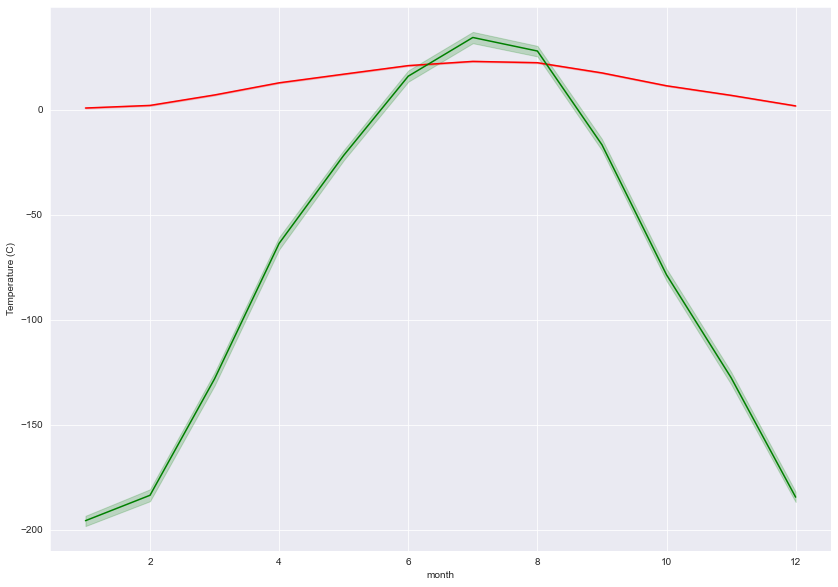

In [259]:
plt.figure(figsize=(14,10))
sns.lineplot(x=X3_test['month'], y=y3_test, color = 'red');
sns.lineplot(x=X3_test['month'], y=model10_predictions, color = 'green');

In [91]:
model_10_mae = mean_absolute_error(y3_test, model10_predictions)
print(f'Model_10 MAE = {model_10_mae.round(3)}')
model_10_mse = mean_squared_error(y3_test, model10_predictions)
print(f'Model_10 MSE = {model_10_mse.round(3)}')
model_10_mape = mean_absolute_percentage_error(y1_test, model10_predictions)
print(f'Model_10 MAPE = {model_10_mape.round(3)}')
model_10_wmape = wmape(y3_test, model10_predictions)
print(f'Model_10 WMAPE = {model_10_wmape.round(3)}')
model_10_r2score = r2_score(y3_test, model10_predictions)
print(f'Model_10 R2Score = {model_10_r2score.round(3)}')

Model_10 MAE = 102.375
Model_10 MSE = 15876.433
Model_10 MAPE = 3071370001199655.5
Model_10 WMAPE = 857.364
Model_10 R2Score = -172.962


WARNING: powyżej jakieś kosmosy wychodzą ..Hmm

Dla wielu zmiennej kumuliją się błędy ?

In [92]:
# model10_weather = SGDRegressor()
# # model10_weather.fit(standardization(X3_train), y3_train) # standaryzujemt tylko X?
# model10_weather.fit(standardization(X1_train), y1_train) # standaryzujemt tylko X?
# model10_predictions = model10_weather.predict(X1_test)

In [93]:
# model_10_mae = mean_absolute_error(y1_test, model10_predictions)
# print(f'Model_10 MAE = {model_10_mae.round(3)}')
# model_10_mse = mean_squared_error(y1_test, model10_predictions)
# print(f'Model_10 MSE = {model_10_mse.round(3)}')
# model_10_mape = mean_absolute_percentage_error(y1_test, model10_predictions)
# print(f'Model_10 MAPE = {model_10_mape.round(3)}')
# model_10_wmape = wmape(y1_test, model10_predictions)
# print(f'Model_10 WMAPE = {model_10_wmape.round(3)}')
# model_10_r2score = r2_score(y1_test, model10_predictions)
# print(f'Model_10 R2Score = {model_10_r2score.round(3)}')

In [94]:
#standardization(X3_train).describe()

### 11. Regresja grzbietowa - wiele zmiennych 

In [260]:
model11_weather = Ridge(alpha = 1)
model11_weather.fit(standardization(X3_train), standardization(y3_train))
model11_predictions = model11_weather.predict(X3_test)

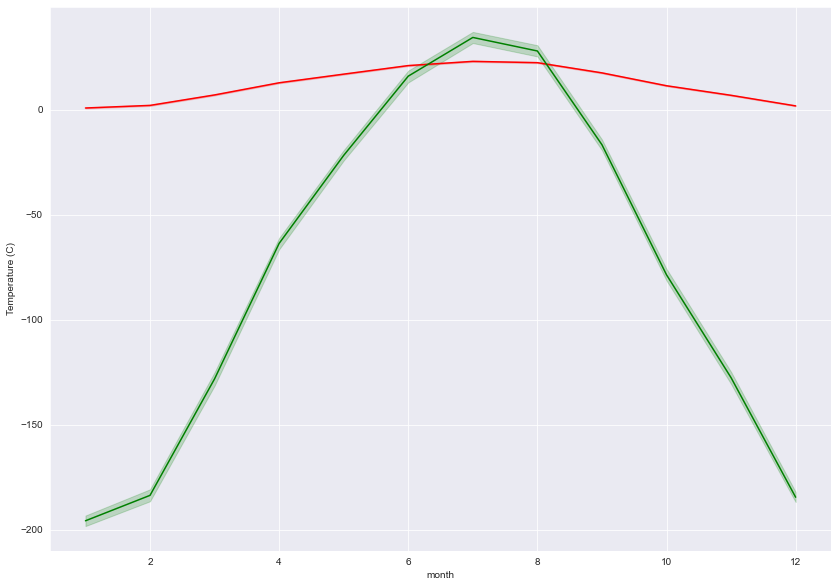

In [261]:
plt.figure(figsize=(14,10))
# sns.scatterplot(x=X1_test['month'], y=y1_test)
sns.lineplot(x=X3_test['month'], y=y3_test, color = 'red');
sns.lineplot(x=X3_test['month'], y=model10_predictions, color = 'green');

In [262]:
model_11_mae = mean_absolute_error(y3_test, model11_predictions)
print(f'Model_11 MAE = {model_11_mae.round(3)}')
model_11_mse = mean_squared_error(y3_test, model11_predictions)
print(f'Model_11 MSE = {model_11_mse.round(3)}')
model_11_mape = mean_absolute_percentage_error(y3_test, model11_predictions)
print(f'Model_11 MAPE = {model_11_mape.round(3)}')
model_11_wmape = wmape(y3_test, model11_predictions)
print(f'Model_11 WMAPE = {model_11_wmape.round(3)}')
model_11_r2score = r2_score(y3_test, model11_predictions)
print(f'Model_11 r2score = {model_11_r2score.round(3)}')

Model_11 MAE = 19.554
Model_11 MSE = 384.347
Model_11 MAPE = 315784678436709.8
Model_11 WMAPE = 163.76
Model_11 r2score = -3.211


### Podsumowanie wyników

In [97]:
data_errors = {'MAE': [model_1_mae.round(3), model_2_mae.round(3), model_3_mae.round(3), model_4_mae.round(3), model_5_mae.round(3), model_6_mae.round(3), model_7_mae.round(3), model_8_mae.round(3), model_9_mae.round(3), model_10_mae.round(3), model_11_mae.round(3)],
        'MSE': [model_1_mse.round(3), model_2_mse.round(3), model_3_mse.round(3), model_4_mse.round(3), model_5_mse.round(3), model_6_mse.round(3), model_7_mse.round(3), model_8_mse.round(3), model_9_mse.round(3), model_10_mse.round(3), model_11_mse.round(3)],
        'MAPE': [model_1_mape.round(3), model_2_mape.round(3), model_3_mape.round(3), model_4_mape.round(3), model_5_mape.round(3), model_6_mape.round(3), model_7_mape.round(3), model_8_mape.round(3), model_9_mape.round(3), model_10_mape.round(3), model_11_mape.round(3)],
        'WMAPE': [model_1_wmape.round(3), model_2_wmape.round(3), model_3_wmape.round(3), model_4_wmape.round(3), model_5_wmape.round(3), model_6_wmape.round(3), model_7_wmape.round(3), model_8_wmape.round(3), model_9_wmape.round(3), model_10_wmape.round(3), model_11_wmape.round(3)],
        'R2Score': [model_1_r2score, model_2_r2score.round(3), model_3_r2score.round(3), model_4_r2score.round(3), model_5_r2score.round(3), model_6_r2score.round(3), model_7_r2score.round(3), model_8_r2score.round(3), model_9_r2score.round(3), model_10_r2score.round(3), model_11_r2score.round(3)]}

podsumowanie = pd.DataFrame(data_errors, index=['1. Regresja liniowa jednej zmiennej', '2. Regresja liniowa + algorytm stochastycznego spadku wzdłuż gradientu ', '3. Model regresji wielomianowej jednej zmiennej', '4. Drzewo decyzyjne', '5. Regresja grzbietowa', '6. Regresja LASSO', '7. Metoda elastycznej siatki', '8. Regresja liniowa dla wielu zmiennych', '9. Regresja wielomianowa dla wielu zmiennych', '10. Model regresji liniowej + algorytm stochastycznego spadku wzdłuż gradientu dla wielu zmiennych', '11. Regresja grzbietowa dla wielu zmiennych'])

podsumowanie

MAE        MSE  \
1. Regresja liniowa jednej zmiennej                   7.814     88.811   
2. Regresja liniowa + algorytm stochastycznego ...    7.831     89.249   
3. Model regresji wielomianowej jednej zmiennej       4.629     32.792   
4. Drzewo decyzyjne                                   5.031     39.780   
5. Regresja grzbietowa                               10.889    184.476   
6. Regresja LASSO                                     7.814     88.811   
7. Metoda elastycznej siatki                          7.846     89.340   
8. Regresja liniowa dla wielu zmiennych               0.735      0.878   
9. Regresja wielomianowa dla wielu zmiennych          0.317      0.175   
10. Model regresji liniowej + algorytm stochast...  102.375  15876.433   
11. Regresja grzbietowa dla wielu zmiennych          19.554    384.347   

                                                            MAPE    WMAPE  \
1. Regresja liniowa jednej zmiennej                 1.628144e+14   65.437   
2. Regresja liniowa + algorytm stochastycznego ...  1.578615e+14   65.581   
3. Model regresji wielomianowej jednej zmiennej     3.903973e+13   38.763   
4. Drzewo decyzyjne                                 4.543874e+13   42.134   
5. Regresja grzbietowa                              2.604247e+14   91.195   
6. Regresja LASSO                                   1.628144e+14   65.437   
7. Metoda elastycznej siatki                        1.695127e+14   65.707   
8. Regresja liniowa dla wielu zmiennych             1.599796e+13    6.151   
9. Regresja wielomianowa dla wielu zmiennych        3.830919e+12    2.656   
10. Model regresji liniowej + algorytm stochast...  3.071370e+15  857.364   
11. Regresja grzbietowa dla wielu zmiennych         3.157847e+14  163.760   

                                                       R2Score  
1. Regresja liniowa jednej zmiennej                   0.026876  
2. Regresja liniowa + algorytm stochastycznego ...    0.022000  
3. Model regresji wielomianowej jednej zmiennej       0.641000  
4. Drzewo decyzyjne                                   0.564000  
5. Regresja grzbietowa                               -1.021000  
6. Regresja LASSO                                     0.027000  
7. Metoda elastycznej siatki                          0.021000  
8. Regresja liniowa dla wielu zmiennych               0.990000  
9. Regresja wielomianowa dla wielu zmiennych          0.998000  
10. Model regresji liniowej + algorytm stochast... -172.962000  
11. Regresja grzbietowa dla wielu zmiennych          -3.211000

# 12. XGBoost analysis 

In [98]:
weather_df_xgb = weather_df
weather_df_xgb = weather_df_xgb.set_index('Formatted Date')
weather_df_xgb = weather_df_xgb.drop(columns=['Temp_diff']) 

# Droping Temp_diff as this is corelated with Temperature (C) and Apparent Temperature (C) 
weather_df_xgb = create_time_features(weather_df_xgb)

weather_df_xgb.head(5)


rain  snow  Temperature (C)  \
Formatted Date                                           
2006-03-31 22:00:00+00:00     1     0         9.472222   
2006-03-31 23:00:00+00:00     1     0         9.355556   
2006-04-01 00:00:00+00:00     1     0         9.377778   
2006-04-01 01:00:00+00:00     1     0         8.288889   
2006-04-01 02:00:00+00:00     1     0         8.755556   

                           Apparent Temperature (C)  Humidity  \
Formatted Date                                                  
2006-03-31 22:00:00+00:00                  7.388889      0.89   
2006-03-31 23:00:00+00:00                  7.227778      0.86   
2006-04-01 00:00:00+00:00                  9.377778      0.89   
2006-04-01 01:00:00+00:00                  5.944444      0.83   
2006-04-01 02:00:00+00:00                  6.977778      0.83   

                           Wind Speed (km/h)  Wind Bearing (degrees)  \
Formatted Date                                                         
2006-03-31 22:00:00+00:00            14.1197                   251.0   
2006-03-31 23:00:00+00:00            14.2646                   259.0   
2006-04-01 00:00:00+00:00             3.9284                   204.0   
2006-04-01 01:00:00+00:00            14.1036                   269.0   
2006-04-01 02:00:00+00:00            11.0446                   259.0   

                           Visibility (km)  Pressure (millibars)  month  year  \
Formatted Date                                                                  
2006-03-31 22:00:00+00:00          15.8263               1015.13      3  2006   
2006-03-31 23:00:00+00:00          15.8263               1015.63      3  2006   
2006-04-01 00:00:00+00:00          14.9569               1015.94      4  2006   
2006-04-01 01:00:00+00:00          15.8263               1016.41      4  2006   
2006-04-01 02:00:00+00:00          15.8263               1016.51      4  2006   

                           hour  DayOfWeek  quarter  DayOfYear  
Formatted Date                                                  
2006-03-31 22:00:00+00:00    22          4        1         90  
2006-03-31 23:00:00+00:00    23          4        1         90  
2006-04-01 00:00:00+00:00     0          5        2         91  
2006-04-01 01:00:00+00:00     1          5        2         91  
2006-04-01 02:00:00+00:00     2          5        2         91

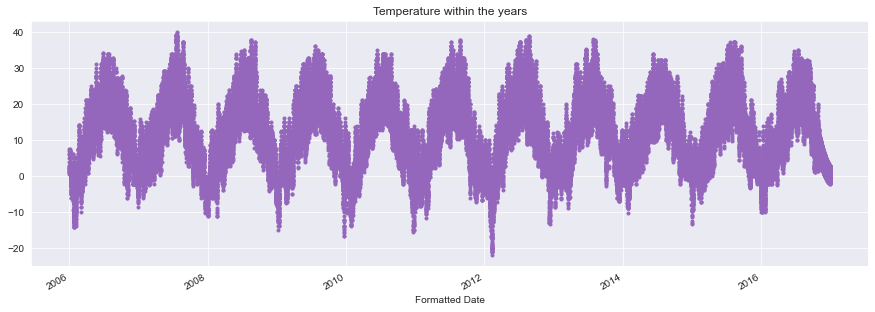

In [99]:
weather_df_xgb['Temperature (C)'].plot(style='.', figsize=(15,5), color=color_pal[4], title='Temperature within the years');


In [100]:
weather_df_xgb.head(2)

rain  snow  Temperature (C)  \
Formatted Date                                           
2006-03-31 22:00:00+00:00     1     0         9.472222   
2006-03-31 23:00:00+00:00     1     0         9.355556   

                           Apparent Temperature (C)  Humidity  \
Formatted Date                                                  
2006-03-31 22:00:00+00:00                  7.388889      0.89   
2006-03-31 23:00:00+00:00                  7.227778      0.86   

                           Wind Speed (km/h)  Wind Bearing (degrees)  \
Formatted Date                                                         
2006-03-31 22:00:00+00:00            14.1197                   251.0   
2006-03-31 23:00:00+00:00            14.2646                   259.0   

                           Visibility (km)  Pressure (millibars)  month  year  \
Formatted Date                                                                  
2006-03-31 22:00:00+00:00          15.8263               1015.13      3  2006   
2006-03-31 23:00:00+00:00          15.8263               1015.63      3  2006   

                           hour  DayOfWeek  quarter  DayOfYear  
Formatted Date                                                  
2006-03-31 22:00:00+00:00    22          4        1         90  
2006-03-31 23:00:00+00:00    23          4        1         90

In [101]:
train_xgb = weather_df_xgb.loc[weather_df_xgb.index < '2013-01-01']
test_xgb = weather_df_xgb.loc[weather_df_xgb.index > '2013-02-01']

In [102]:
train_xgb.tail(2)

rain  snow  Temperature (C)  \
Formatted Date                                           
2012-09-09 21:00:00+00:00     1     0        20.700000   
2012-12-31 23:00:00+00:00     0     1        -2.038889   

                           Apparent Temperature (C)  Humidity  \
Formatted Date                                                  
2012-09-09 21:00:00+00:00                 20.700000      0.46   
2012-12-31 23:00:00+00:00                 -5.072222      0.99   

                           Wind Speed (km/h)  Wind Bearing (degrees)  \
Formatted Date                                                         
2012-09-09 21:00:00+00:00            12.9122                    77.0   
2012-12-31 23:00:00+00:00             7.8890                   103.0   

                           Visibility (km)  Pressure (millibars)  month  year  \
Formatted Date                                                                  
2012-09-09 21:00:00+00:00          14.9569               1019.47      9  2012   
2012-12-31 23:00:00+00:00           2.2701               1019.80     12  2012   

                           hour  DayOfWeek  quarter  DayOfYear  
Formatted Date                                                  
2012-09-09 21:00:00+00:00    21          6        3        253  
2012-12-31 23:00:00+00:00    23          0        4        366

DLACZEGO POKAZUJE MI DZIURĘ W WARTOŚCIACH ???

In [103]:
test_xgb.head(3)

rain  snow  Temperature (C)  \
Formatted Date                                           
2013-03-31 22:00:00+00:00     1     0         2.105556   
2013-03-31 23:00:00+00:00     1     0         1.550000   
2013-04-01 00:00:00+00:00     1     0         0.661111   

                           Apparent Temperature (C)  Humidity  \
Formatted Date                                                  
2013-03-31 22:00:00+00:00                 -2.622222      0.82   
2013-03-31 23:00:00+00:00                 -2.388889      0.82   
2013-04-01 00:00:00+00:00                 -2.850000      0.88   

                           Wind Speed (km/h)  Wind Bearing (degrees)  \
Formatted Date                                                         
2013-03-31 22:00:00+00:00            20.4148                   298.0   
2013-03-31 23:00:00+00:00            14.4578                   270.0   
2013-04-01 00:00:00+00:00            11.4149                   272.0   

                           Visibility (km)  Pressure (millibars)  month  year  \
Formatted Date                                                                  
2013-03-31 22:00:00+00:00          15.8263               1005.58      3  2013   
2013-03-31 23:00:00+00:00          15.8263               1006.29      3  2013   
2013-04-01 00:00:00+00:00          14.9569               1006.35      4  2013   

                           hour  DayOfWeek  quarter  DayOfYear  
Formatted Date                                                  
2013-03-31 22:00:00+00:00    22          6        1         90  
2013-03-31 23:00:00+00:00    23          6        1         90  
2013-04-01 00:00:00+00:00     0          0        2         91

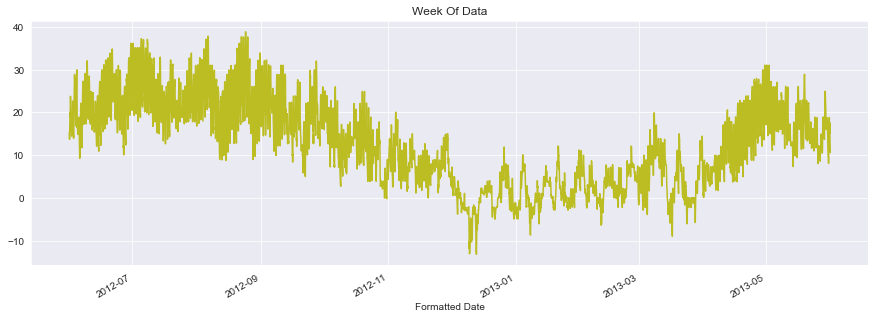

In [104]:
#fix, ax = plt.subplots(figsize=(15,5));
weather_df_xgb['Temperature (C)'].loc[(weather_df_xgb.index > '2012-06-01') & (weather_df_xgb.index < '2013-06-01')] \
    .plot(figsize=(15, 5), title='Week Of Data', color=color_pal[8])
plt.show()

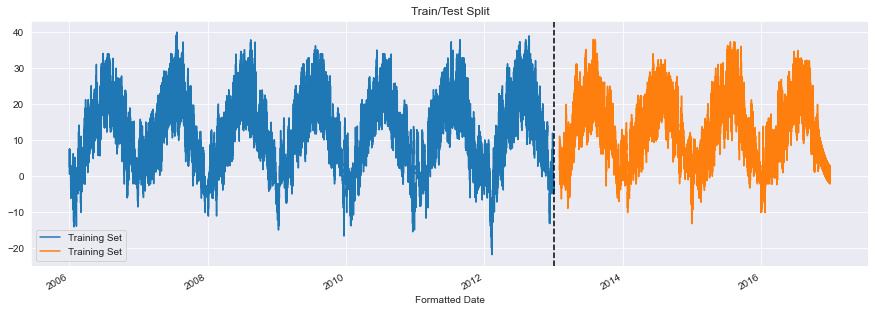

In [105]:
fix, ax = plt.subplots(figsize=(15,5));
train_xgb.plot(ax=ax, y='Temperature (C)', label='Training Set', color=color_pal[0], title='Train/Test Split');
test_xgb.plot(ax=ax, y='Temperature (C)', label='Training Set', color=color_pal[1]);
ax.axvline('2013-01-01', color='black', ls='--')
plt.show()


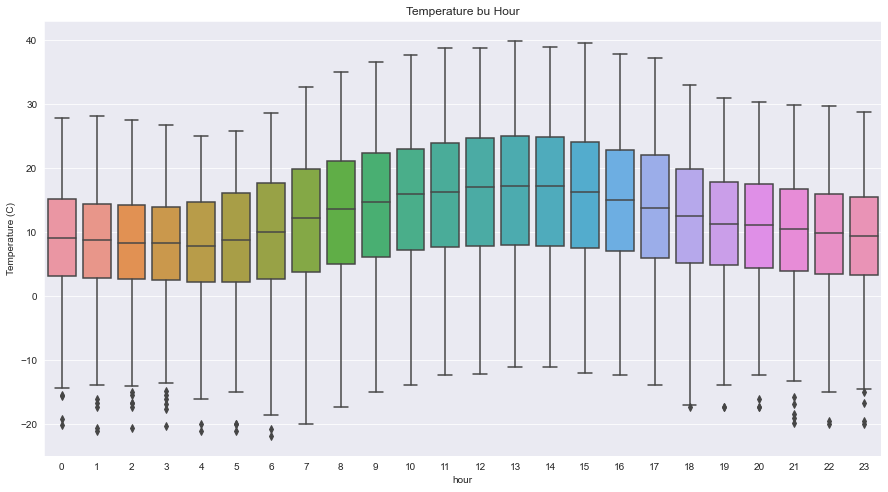

In [106]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=weather_df_xgb, x='hour', y='Temperature (C)');
ax.set_title('Temperature bu Hour');

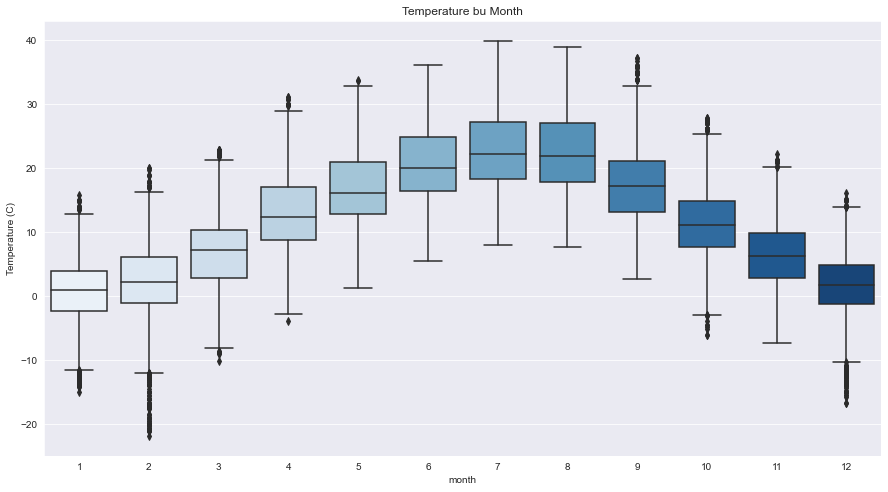

In [107]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=weather_df_xgb, x='month', y='Temperature (C)', palette='Blues');
ax.set_title('Temperature bu Month');

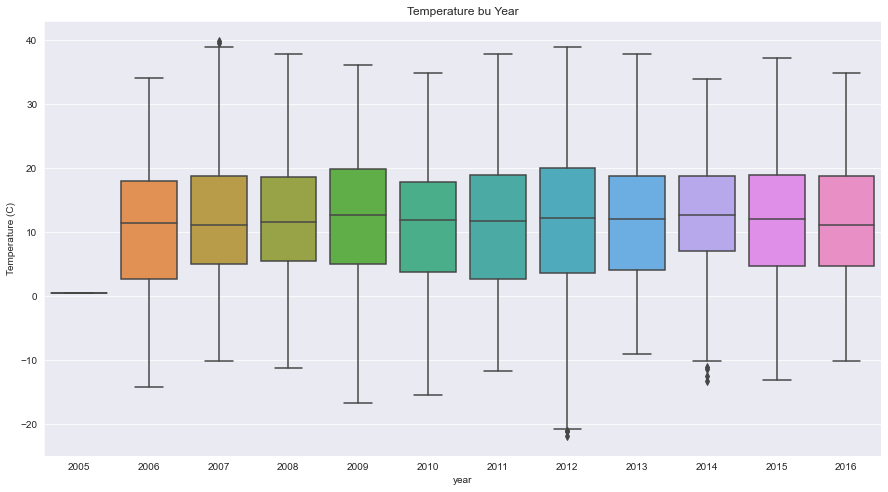

In [108]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=weather_df_xgb, x='year', y='Temperature (C)');
ax.set_title('Temperature bu Year');

#TODO: Clear year 2005 

In [109]:
weather_df_xgb.columns

Index(['rain', 'snow', 'Temperature (C)', 'Apparent Temperature (C)',
       'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
       'Visibility (km)', 'Pressure (millibars)', 'month', 'year', 'hour',
       'DayOfWeek', 'quarter', 'DayOfYear'],
      dtype='object')

In [110]:
FEATURES_1 = ['rain', 'snow', 'Apparent Temperature (C)',
       'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
       'Visibility (km)', 'Pressure (millibars)', 'month', 'year', 'hour',
       'DayOfWeek', 'quarter', 'DayOfYear']

FEATURES_2 = ['Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
            'Visibility (km)', 'Pressure (millibars)', 'month', 'year', 'hour',
            'DayOfWeek', 'quarter', 'DayOfYear']


TARGET = 'Temperature (C)'

In [111]:
X_train_xgb = train_xgb[FEATURES_2]
y_train_xgb = train_xgb[TARGET]

X_test_xgb = test_xgb[FEATURES_2]
y_test_xgb = test_xgb[TARGET]

In [112]:
X_train_xgb.tail(2)

Humidity  Wind Speed (km/h)  \
Formatted Date                                           
2012-09-09 21:00:00+00:00      0.46            12.9122   
2012-12-31 23:00:00+00:00      0.99             7.8890   

                           Wind Bearing (degrees)  Visibility (km)  \
Formatted Date                                                       
2012-09-09 21:00:00+00:00                    77.0          14.9569   
2012-12-31 23:00:00+00:00                   103.0           2.2701   

                           Pressure (millibars)  month  year  hour  DayOfWeek  \
Formatted Date                                                                  
2012-09-09 21:00:00+00:00               1019.47      9  2012    21          6   
2012-12-31 23:00:00+00:00               1019.80     12  2012    23          0   

                           quarter  DayOfYear  
Formatted Date                                 
2012-09-09 21:00:00+00:00        3        253  
2012-12-31 23:00:00+00:00        4        366

In [113]:
X_test_xgb.head(2)

Humidity  Wind Speed (km/h)  \
Formatted Date                                           
2013-03-31 22:00:00+00:00      0.82            20.4148   
2013-03-31 23:00:00+00:00      0.82            14.4578   

                           Wind Bearing (degrees)  Visibility (km)  \
Formatted Date                                                       
2013-03-31 22:00:00+00:00                   298.0          15.8263   
2013-03-31 23:00:00+00:00                   270.0          15.8263   

                           Pressure (millibars)  month  year  hour  DayOfWeek  \
Formatted Date                                                                  
2013-03-31 22:00:00+00:00               1005.58      3  2013    22          6   
2013-03-31 23:00:00+00:00               1006.29      3  2013    23          6   

                           quarter  DayOfYear  
Formatted Date                                 
2013-03-31 22:00:00+00:00        1         90  
2013-03-31 23:00:00+00:00        1         90

In [114]:
reg_xgb = xgb.XGBRegressor(n_estimators=100, early_stopping_rounds=50) # learning_rate=0.01
reg_xgb.fit(X_train_xgb, y_train_xgb, 
        eval_set=[(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)],
        verbose=10) #verbose=100 or verbose=True


[0]	validation_0-rmse:10.81751	validation_1-rmse:10.92607
[10]	validation_0-rmse:2.91906	validation_1-rmse:3.61824
[20]	validation_0-rmse:2.56716	validation_1-rmse:3.65036
[30]	validation_0-rmse:2.38230	validation_1-rmse:3.68783
[40]	validation_0-rmse:2.22535	validation_1-rmse:3.74009
[50]	validation_0-rmse:2.09853	validation_1-rmse:3.77885
[60]	validation_0-rmse:1.97211	validation_1-rmse:3.82121
[61]	validation_0-rmse:1.96758	validation_1-rmse:3.82428


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance

In [115]:
feature_importance = pd.DataFrame(data=reg_xgb.feature_importances_,
             index=reg_xgb.feature_names_in_,
             columns=['importance'])

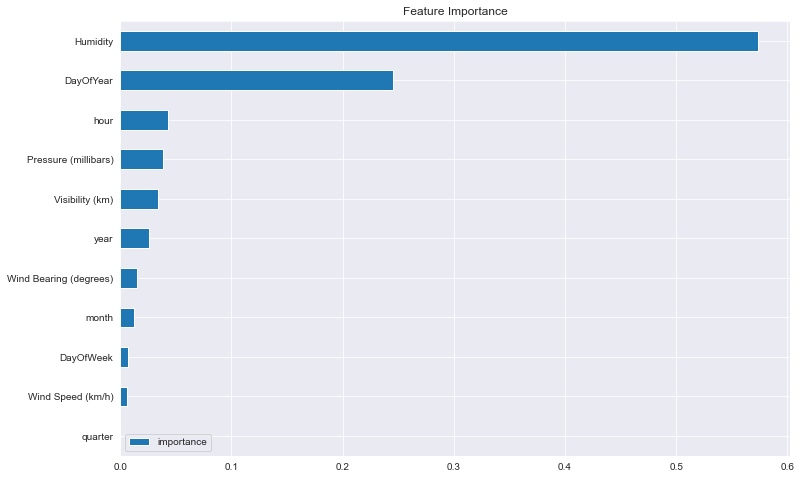

In [116]:
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(12, 8))
plt.show()

**Comment:** When all Features are used:
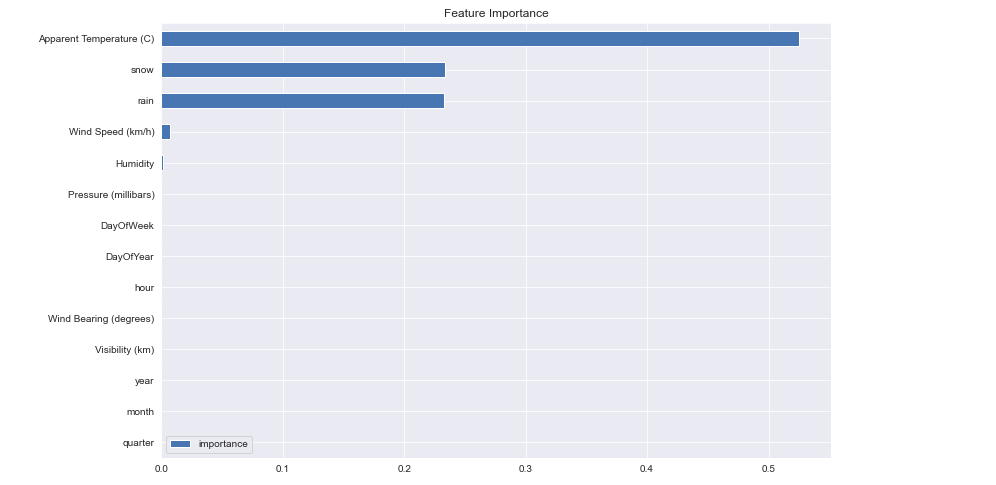

**Comment:**: When some Features are used:
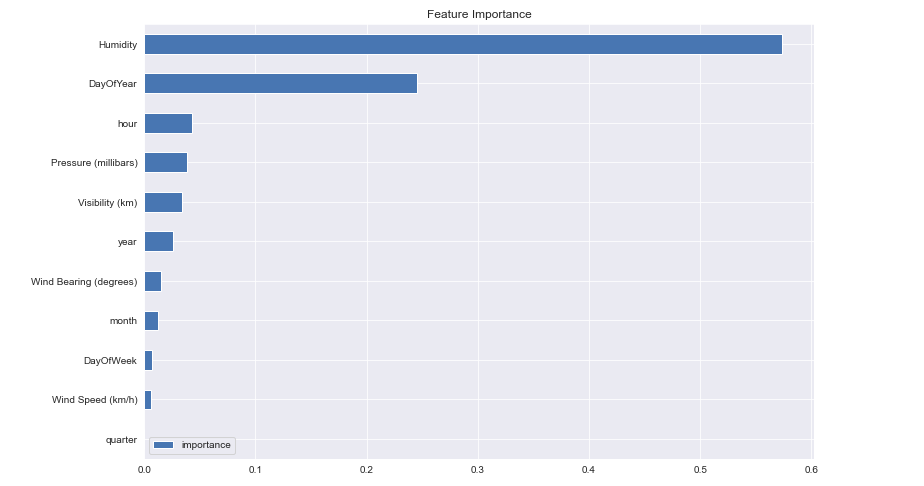
        

## Forecast on Test Set:

In [117]:
test_xgb['prediction'] = reg_xgb.predict(X_test_xgb)

test_xgb.head()

/var/folders/mh/h9kggxls72d7fqvcpf0sm_xc0000gn/T/ipykernel_99912/3111922361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_xgb['prediction'] = reg_xgb.predict(X_test_xgb)


rain  snow  Temperature (C)  \
Formatted Date                                           
2013-03-31 22:00:00+00:00     1     0         2.105556   
2013-03-31 23:00:00+00:00     1     0         1.550000   
2013-04-01 00:00:00+00:00     1     0         0.661111   
2013-04-01 01:00:00+00:00     1     0         0.511111   
2013-04-01 02:00:00+00:00     1     0         0.533333   

                           Apparent Temperature (C)  Humidity  \
Formatted Date                                                  
2013-03-31 22:00:00+00:00                 -2.622222      0.82   
2013-03-31 23:00:00+00:00                 -2.388889      0.82   
2013-04-01 00:00:00+00:00                 -2.850000      0.88   
2013-04-01 01:00:00+00:00                 -3.638889      0.85   
2013-04-01 02:00:00+00:00                 -3.650000      0.85   

                           Wind Speed (km/h)  Wind Bearing (degrees)  \
Formatted Date                                                         
2013-03-31 22:00:00+00:00            20.4148                   298.0   
2013-03-31 23:00:00+00:00            14.4578                   270.0   
2013-04-01 00:00:00+00:00            11.4149                   272.0   
2013-04-01 01:00:00+00:00            14.3129                   270.0   
2013-04-01 02:00:00+00:00            14.5222                   279.0   

                           Visibility (km)  Pressure (millibars)  month  year  \
Formatted Date                                                                  
2013-03-31 22:00:00+00:00          15.8263               1005.58      3  2013   
2013-03-31 23:00:00+00:00          15.8263               1006.29      3  2013   
2013-04-01 00:00:00+00:00          14.9569               1006.35      4  2013   
2013-04-01 01:00:00+00:00          15.8263               1006.59      4  2013   
2013-04-01 02:00:00+00:00          15.8263               1006.88      4  2013   

                           hour  DayOfWeek  quarter  DayOfYear  prediction  
Formatted Date                                                              
2013-03-31 22:00:00+00:00    22          6        1         90    8.245289  
2013-03-31 23:00:00+00:00    23          6        1         90    8.245289  
2013-04-01 00:00:00+00:00     0          0        2         91    6.718632  
2013-04-01 01:00:00+00:00     1          0        2         91    6.543423  
2013-04-01 02:00:00+00:00     2          0        2         91    6.543423

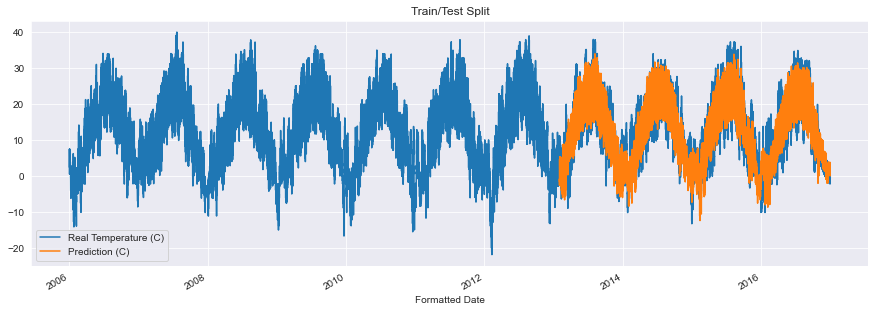

In [118]:
fix, ax = plt.subplots(figsize=(15,5));
weather_df_xgb.plot(ax=ax, y='Temperature (C)', label='Real Temperature (C)', color=color_pal[0], title='Train/Test Split');
test_xgb.plot(ax=ax, y='prediction', label='Prediction (C)', color=color_pal[1]);
# ax.axvline('2013-01-01', color='black', ls='--')
plt.show()


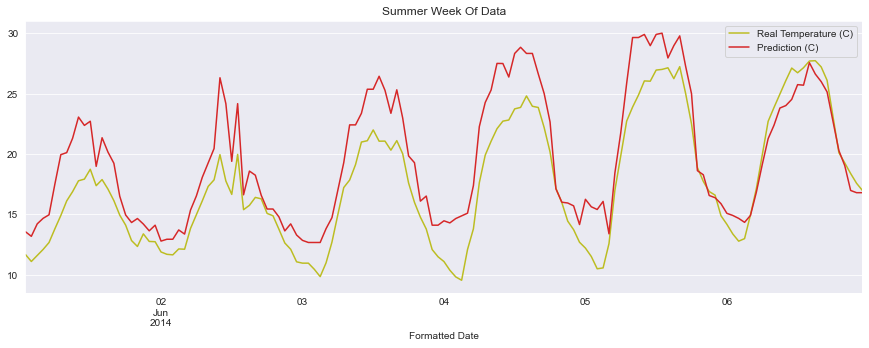

In [119]:
fix, ax = plt.subplots(figsize=(15,5));

weather_df_xgb['Temperature (C)'].loc[(weather_df_xgb.index > '2014-06-01') & (weather_df_xgb.index < '2014-06-07')] \
    .plot(figsize=(15, 5), label='Real Temperature (C)', color=color_pal[8])

test_xgb['prediction'].loc[(test_xgb.index > '2014-06-01') & (test_xgb.index < '2014-06-07')] \
        .plot(figsize=(15, 5), title='Summer Week Of Data', label='Prediction (C)', color=color_pal[3])

plt.legend()
plt.show()

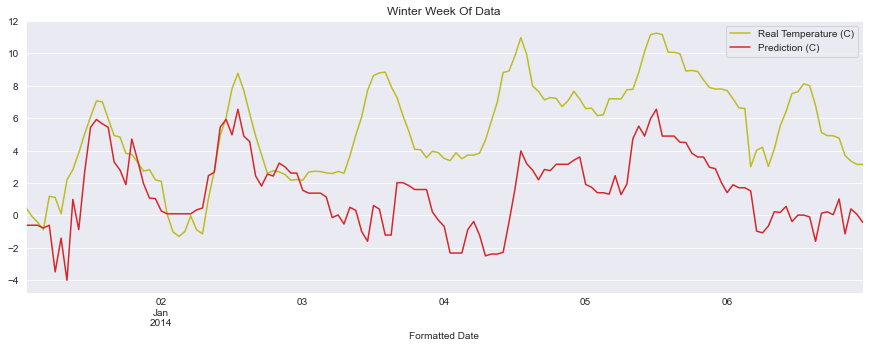

In [120]:
fix, ax = plt.subplots(figsize=(15,5));

weather_df_xgb['Temperature (C)'].loc[(weather_df_xgb.index > '2014-01-01') & (weather_df_xgb.index < '2014-01-07')] \
    .plot(figsize=(15, 5), label='Real Temperature (C)', title='Winter Week Of Data', color=color_pal[8])

test_xgb['prediction'].loc[(test_xgb.index > '2014-01-01') & (test_xgb.index < '2014-01-07')] \
        .plot(figsize=(15, 5), title='Winter Week Of Data', label='Prediction (C)', color=color_pal[3])

plt.legend()
plt.show()

### Testing the results:

In [121]:
score = np.sqrt(mean_squared_error(test_xgb['Temperature (C)'], test_xgb['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3.61


### Calculate Error:
- looking at the worst and best predicting days

In [122]:
test_xgb['error'] = np.abs(test_xgb[TARGET] - test_xgb['prediction']);

test_xgb.head(3)

/var/folders/mh/h9kggxls72d7fqvcpf0sm_xc0000gn/T/ipykernel_99912/4171554889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_xgb['error'] = np.abs(test_xgb[TARGET] - test_xgb['prediction']);


rain  snow  Temperature (C)  \
Formatted Date                                           
2013-03-31 22:00:00+00:00     1     0         2.105556   
2013-03-31 23:00:00+00:00     1     0         1.550000   
2013-04-01 00:00:00+00:00     1     0         0.661111   

                           Apparent Temperature (C)  Humidity  \
Formatted Date                                                  
2013-03-31 22:00:00+00:00                 -2.622222      0.82   
2013-03-31 23:00:00+00:00                 -2.388889      0.82   
2013-04-01 00:00:00+00:00                 -2.850000      0.88   

                           Wind Speed (km/h)  Wind Bearing (degrees)  \
Formatted Date                                                         
2013-03-31 22:00:00+00:00            20.4148                   298.0   
2013-03-31 23:00:00+00:00            14.4578                   270.0   
2013-04-01 00:00:00+00:00            11.4149                   272.0   

                           Visibility (km)  Pressure (millibars)  month  year  \
Formatted Date                                                                  
2013-03-31 22:00:00+00:00          15.8263               1005.58      3  2013   
2013-03-31 23:00:00+00:00          15.8263               1006.29      3  2013   
2013-04-01 00:00:00+00:00          14.9569               1006.35      4  2013   

                           hour  DayOfWeek  quarter  DayOfYear  prediction  \
Formatted Date                                                               
2013-03-31 22:00:00+00:00    22          6        1         90    8.245289   
2013-03-31 23:00:00+00:00    23          6        1         90    8.245289   
2013-04-01 00:00:00+00:00     0          0        2         91    6.718632   

                              error  
Formatted Date                       
2013-03-31 22:00:00+00:00  6.139733  
2013-03-31 23:00:00+00:00  6.695289  
2013-04-01 00:00:00+00:00  6.057521

In [123]:
test_xgb['date'] = test_xgb.index.date
test_xgb.head(3)

/var/folders/mh/h9kggxls72d7fqvcpf0sm_xc0000gn/T/ipykernel_99912/816944343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_xgb['date'] = test_xgb.index.date


rain  snow  Temperature (C)  \
Formatted Date                                           
2013-03-31 22:00:00+00:00     1     0         2.105556   
2013-03-31 23:00:00+00:00     1     0         1.550000   
2013-04-01 00:00:00+00:00     1     0         0.661111   

                           Apparent Temperature (C)  Humidity  \
Formatted Date                                                  
2013-03-31 22:00:00+00:00                 -2.622222      0.82   
2013-03-31 23:00:00+00:00                 -2.388889      0.82   
2013-04-01 00:00:00+00:00                 -2.850000      0.88   

                           Wind Speed (km/h)  Wind Bearing (degrees)  \
Formatted Date                                                         
2013-03-31 22:00:00+00:00            20.4148                   298.0   
2013-03-31 23:00:00+00:00            14.4578                   270.0   
2013-04-01 00:00:00+00:00            11.4149                   272.0   

                           Visibility (km)  Pressure (millibars)  month  year  \
Formatted Date                                                                  
2013-03-31 22:00:00+00:00          15.8263               1005.58      3  2013   
2013-03-31 23:00:00+00:00          15.8263               1006.29      3  2013   
2013-04-01 00:00:00+00:00          14.9569               1006.35      4  2013   

                           hour  DayOfWeek  quarter  DayOfYear  prediction  \
Formatted Date                                                               
2013-03-31 22:00:00+00:00    22          6        1         90    8.245289   
2013-03-31 23:00:00+00:00    23          6        1         90    8.245289   
2013-04-01 00:00:00+00:00     0          0        2         91    6.718632   

                              error        date  
Formatted Date                                   
2013-03-31 22:00:00+00:00  6.139733  2013-03-31  
2013-03-31 23:00:00+00:00  6.695289  2013-03-31  
2013-04-01 00:00:00+00:00  6.057521  2013-04-01

In [124]:
test_xgb.groupby('date')['error'].mean().sort_values(ascending=False).head(3)

date
2016-02-16    12.184081
2013-03-24    11.948372
2016-01-04    11.312605
Name: error, dtype: float64

In [125]:
test_xgb.groupby('date')['error'].mean().sort_values(ascending=True).head(3)

date
2015-09-28    0.330067
2016-10-21    0.516254
2014-05-03    0.516587
Name: error, dtype: float64

Results: <br>

<br>
**For limited dataset:** <br>
['Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
            'Visibility (km)', 'Pressure (millibars)', 'month', 'year', 'hour',
            'DayOfWeek', 'quarter', 'DayOfYear'] <br>
            
RMSE Score on Test set: 3.61 <br>
Highest Error: 2016-02-16    12.184081 <br>
Slammels Error: 2015-09-28    0.330067 <br>

**For whole dataset:** <br>
[**'rain', 'snow', 'Apparent Temperature (C)'**,
'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
'Visibility (km)', 'Pressure (millibars)', 'month', 'year', 'hour',
'DayOfWeek', 'quarter', 'DayOfYear'] <br>


RMSE Score on Test set: 0.07 <br>
2016-10-27    0.229968 <br>
2013-05-22    0.008124 <br> 

### K-Fold i Leave One Out crosswalidacja wybranych modeli

In [126]:
#For Leave One Out Method, we will use only some samples
num_of_sumples = 10000

X1_sample = X1[:num_of_sumples]
# X1_sample = X1.sample(n=num_of_sumples, random_state=42)
# X1_sample.reset_index(drop=True, inplace=True)

# X1_sample.tail()

X3_sample = X3[:num_of_sumples]
# X3_sample = X3.sample(n=num_of_sumples, random_state=42)
# X3_sample.reset_index(drop=True, inplace=True)
# X3_sample.tail()

y_sample = y[:num_of_sumples] # .round(3)
# y_sample = y.sample(n=num_of_sumples, random_state=42)
# y_sample.reset_index(drop=True, inplace=True)
# y_sample.tail()

# print(y_sample.head)
# y_sample
# print(X3_sample.head())

# X1_sample


In [127]:
# plt.figure(figsize=(14,10))
# fig = X1_sample['month'].hist(bins=100)
# fig.set_ylabel('Number of observations')
# fig.set_xlabel('Temperature (C)')

##### Model 3 - Model regresji wielomianowej (możliwość dostrojenia hiperparametrów) - 1 parametr - K-Fold


In [128]:
from sklearn.model_selection import cross_val_score

In [129]:
kfold_model3 = KFold(n_splits=5, shuffle=True, random_state=42)

In [130]:
scores = cross_val_score(model3_weather, poly.fit_transform(X1), y, scoring='r2', cv=kfold_model3) # testujemy na całym zbiorze ?



In [131]:
print('Cross-validation scores:', scores)
print('Average cross-validation score:', -scores.mean())
print('Standard deviation of cross-validation scores:', scores.std())

Cross-validation scores: [0.64067931 0.64172286 0.64367751 0.63848057 0.64594196]
Average cross-validation score: -0.6421004410115143
Standard deviation of cross-validation scores: 0.0025499037235092183


##### Model 3 - Model regresji wielomianowej (możliwość dostrojenia hiperparametrów) - 1 parametr - Leave One Out


In [132]:
scores_loo_3 = cross_val_score(model3_weather, poly.fit_transform(X1_sample), y_sample, scoring='neg_mean_squared_error',
                         cv=LeaveOneOut())

print('Average cross-validation score:', scores_loo_3.mean())
print('Standard deviation of cross-validation scores:', scores_loo_3.std())


Average cross-validation score: -30.206062877533398
Standard deviation of cross-validation scores: 39.61587565954655


##### Model 9 - Regresja wielomianowa dla wielu zmiennych - K-Fold

In [133]:
kfold_model9 = KFold(n_splits=5, shuffle=True, random_state=42)

In [134]:
scores = cross_val_score(model9_weather, poly.fit_transform(X3), y, scoring='r2', cv=kfold_model9)

In [135]:
print('Cross-validation scores:', scores)
print('Average cross-validation score:', -scores.mean())
print('Standard deviation of cross-validation scores:', scores.std())

Cross-validation scores: [0.99808936 0.9980706  0.99804257 0.99807788 0.99803804]
Average cross-validation score: -0.998063689352312
Standard deviation of cross-validation scores: 2.0058326156194314e-05


##### Model 9 - Regresja wielomianowa dla wielu zmiennych - Leave One Out

In [136]:
# scores_loo_9 = cross_val_score(model9_weather, poly.fit_transform(X3_sample), y_sample, scoring='neg_mean_squared_error',
#                          cv=LeaveOneOut(), n_jobs=-1)


# print('Average cross-validation score:', scores_loo_9.mean())
# print('Standard deviation of cross-validation scores:', scores_loo_9.std())


##### Model 11 - Regresja grzbietowa - K-Fold

In [137]:
model11_weather = Ridge(alpha = 1)

In [138]:
kfold_model11 = KFold(n_splits=5, shuffle=True, random_state=1)

In [139]:
scores = cross_val_score(model11_weather, X3, y, scoring='r2', cv=kfold_model11)

In [140]:
print('Cross-validation scores:', scores)
print('Average cross-validation score:', -scores.mean())
print('Standard deviation of cross-validation scores:', scores.std())

Cross-validation scores: [0.99025769 0.99039363 0.99040724 0.99040922 0.99042971]
Average cross-validation score: -0.9903794990348939
Standard deviation of cross-validation scores: 6.198415203207467e-05


##### Model 11 - Regresja grzbietowa - Leave One Out

In [141]:
# scores_loo_11 = cross_val_score(model11_weather, X3_sample, y_sample, scoring='neg_mean_squared_error',
#                          cv=LeaveOneOut(), n_jobs=-1)


# print('Average cross-validation score:', scores_loo_11.mean())
# print('Standard deviation of cross-validation scores:', scores_loo_11.std())


 ### Predykcja algorytmu dla 4 losowych wartości spoza zbioru danych (1 zmienna - Month, model nr. 3)

In [143]:
random_df = pd.read_csv('4_random_features.csv', sep=';')
random_df


month  Humidity  Apparent Temperature (C)  Wind Speed (km/h)  \
0      4      0.90                         6                 16   
1     12      0.91                        -1                  4   
2      1      0.80                         0                 24   
3      7      0.99                        18                 24   

   Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  rain  snow  \
0                   251.0               15                  1026     1     0   
1                   213.0               12                  1035     0     1   
2                   149.0               15                  1010     0     1   
3                    30.0               16                  1017     1     0   

   Temperature (C)  
0              NaN  
1              NaN  
2              NaN  
3              NaN

In [144]:
Xrandom = random_df[['month']]

poly_random = poly.fit_transform(Xrandom)

Xrandom

month
0      4
1     12
2      1
3      7

In [145]:
model3_pred_outsideset = model3_weather.predict(poly_random)
model3_pred_outsideset = np.round(model3_pred_outsideset, decimals=1)

In [146]:
random_df['Temperature (C)'] = model3_pred_outsideset
random_df

month  Humidity  Apparent Temperature (C)  Wind Speed (km/h)  \
0      4      0.90                         6                 16   
1     12      0.91                        -1                  4   
2      1      0.80                         0                 24   
3      7      0.99                        18                 24   

   Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  rain  snow  \
0                   251.0               15                  1026     1     0   
1                   213.0               12                  1035     0     1   
2                   149.0               15                  1010     0     1   
3                    30.0               16                  1017     1     0   

   Temperature (C)  
0             13.3  
1             -0.7  
2             -1.2  
3             20.7

 ### Predykcja algorytmu dla 4 losowych wartości spoza zbioru danych (wiele zmiennych - Month, model nr. 9)

In [148]:
random_values_x3 = pd.read_csv('4_random_features.csv', sep=';')
random_values_x3

month  Humidity  Apparent Temperature (C)  Wind Speed (km/h)  \
0      4      0.90                         6                 16   
1     12      0.91                        -1                  4   
2      1      0.80                         0                 24   
3      7      0.99                        18                 24   

   Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  rain  snow  \
0                   251.0               15                  1026     1     0   
1                   213.0               12                  1035     0     1   
2                   149.0               15                  1010     0     1   
3                    30.0               16                  1017     1     0   

   Temperature (C)  
0              NaN  
1              NaN  
2              NaN  
3              NaN

In [149]:
Xrandom_X3 = random_values_x3[['month','Humidity','Apparent Temperature (C)','Wind Speed (km/h)','Wind Bearing (degrees)', 'Visibility (km)',
       'Pressure (millibars)', 'rain', 'snow']]
Xrandom_X3

month  Humidity  Apparent Temperature (C)  Wind Speed (km/h)  \
0      4      0.90                         6                 16   
1     12      0.91                        -1                  4   
2      1      0.80                         0                 24   
3      7      0.99                        18                 24   

   Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  rain  snow  
0                   251.0               15                  1026     1     0  
1                   213.0               12                  1035     0     1  
2                   149.0               15                  1010     0     1  
3                    30.0               16                  1017     1     0

In [150]:
poly_random_X3 = poly.fit_transform(Xrandom_X3)

In [151]:
model3_pred_outsideset_X3 = model9_weather.predict(poly_random_X3)
model3_pred_outsideset_X3 = np.round(model3_pred_outsideset_X3, decimals=1)

In [152]:
Xrandom_X3['Temperature (C)'] = model3_pred_outsideset_X3
Xrandom_X3

month  Humidity  Apparent Temperature (C)  Wind Speed (km/h)  \
0      4      0.90                         6                 16   
1     12      0.91                        -1                  4   
2      1      0.80                         0                 24   
3      7      0.99                        18                 24   

   Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  rain  snow  \
0                   251.0               15                  1026     1     0   
1                   213.0               12                  1035     0     1   
2                   149.0               15                  1010     0     1   
3                    30.0               16                  1017     1     0   

   Temperature (C)  
0              7.8  
1             -0.3  
2              4.8  
3             17.8

### WNIOSKI

Jako najlepszy wybraliśmy model regresji wielomianowej dla wielu zmiennych, 
który charakteryzuje się relatywnie najkorzystniejszymi metrykami skuteczności modelu. Model trafnie przewidział wartości temperatur dla losowo wybranych wartości spoza zbioru danych.

### PYTANIA

1. Czy dla przebiegów czasowych nie lepiej jest podzielić dane na dwa okresy zamiast dzielić je przypadkowo ? <br>
2. Czy nie powinnismy ustalić indeksu na 'Formatted Date' na początku i posługiwać się tylko tym indeksem? <br>